<a target="_blank" href="https://colab.research.google.com/github/Bop2000/DANTE/blob/main/notebooks/DANTE_VL_Electron_Ptychography_Reconstruction_Optimization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


################################################################################
> # **Clone GitHub repository**
################################################################################


In [ ]:
################# Clone repository from github to colab session ################

"""

run this section if you want to clone the dataset from the GitHub repository to this colab session

"""


print("Start============================================================================================")

!git clone https://github.com/Bop2000/DANTE

print("Done============================================================================================")



Start============================================================================================
Cloning into 'DOTS'...
remote: Enumerating objects: 1409, done.
remote: Counting objects: 100% (936/936), done.
remote: Compressing objects: 100% (625/625), done.
remote: Total 1409 (delta 347), reused 821 (delta 309), pack-reused 473
Receiving objects: 100% (1409/1409), 402.68 MiB | 10.11 MiB/s, done.
Resolving deltas: 100% (391/391), done.
Done============================================================================================


In [ ]:
"""

run this section if you want to copy all files and folders from cloned folder
(DANTE/SelfDriving_Virtual_Labs/Electron_Ptychography) to current directory (/content/ or ./)

"""

print("============================================================================================")

!cp -rv ./DANTE/SelfDriving_Virtual_Labs/Electron_Ptychography/* ./

print("============================================================================================")


'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychography/ptycho_Si-110_18nm.h5' -> './ptycho_Si-110_18nm.h5'
'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychography/requirements.txt' -> './requirements.txt'
'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychography/Source_Data' -> './Source_Data'
'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychography/Source_Data/BO.py' -> './Source_Data/BO.py'
'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychography/Source_Data/DOTS.py' -> './Source_Data/DOTS.py'
'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychography/Source_Data/README.md' -> './Source_Data/README.md'
'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychography/Source_Data/TuRBO5.py' -> './Source_Data/TuRBO5.py'
'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychography/Source_Data/initial.csv' -> './Source_Data/initial.csv'
'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychography/Source_Data/ptycho_Si-110_18nm.h5' -> './Source_Data/ptycho_Si-110_18nm.h5'
'./DOTS/SelfDriving_Virtual_Labs/Electron_Ptychogra

In [ ]:

"""

run this section if you want to delete original cloned folder and the cloned ipynb file
(after you have copied its contents to current directory)

"""


print("============================================================================================")

# delete original cloned folder
!rm -r ./DANTE

# delete cloned ipynb file
!rm ./DANTE_VL_Electron_Ptychography_Reconstruction_Optimization.ipynb

print("============================================================================================")



rm: remove write-protected regular file './DOTS/.git/objects/pack/pack-eb681249c6cbfd65d44180bd7a56a94fbe7015f3.idx'? ^C


################################################################################
> # **Install Dependencies**
################################################################################


The following libraries are necessary for running the codes.

**To install a GPU version `py4dstem`, you can find the instructions [here](https://py4dstem.readthedocs.io/en/latest/installation.html).** Moreover, to use TuRBO for optimization, you need to install TuRBO first (see instruction [here](https://github.com/uber-research/TuRBO/)).



In [ ]:

############ install compatible version of py4dstem and other packages ###########

# !pip install py4dstem[cuda]

# !pip install scipy

# !pip install numpy

# !pip install pandas

# !pip install matplotlib

# !pip install scikit-learn

# !pip install scikit-image

# !pip install tqdm



################################################################################
> # **Introduction**
> The notebook is divided into 4 major parts :

*   **Part I** : import dataset and visulization expert params
*   **Part II** : define DANTE algorithm
*   **Part III** : optimization using DANTE

################################################################################

################################################################################
> # **Part - I**

*   Import initial dataset
*   Visulization of reconstructed patterns using expert params
*   Set parameters

################################################################################

0.14.8
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 256 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 256/256 [00:07<00:00, 36.23 iter/s]


NMSE of Expert params: 0.29666972160339355


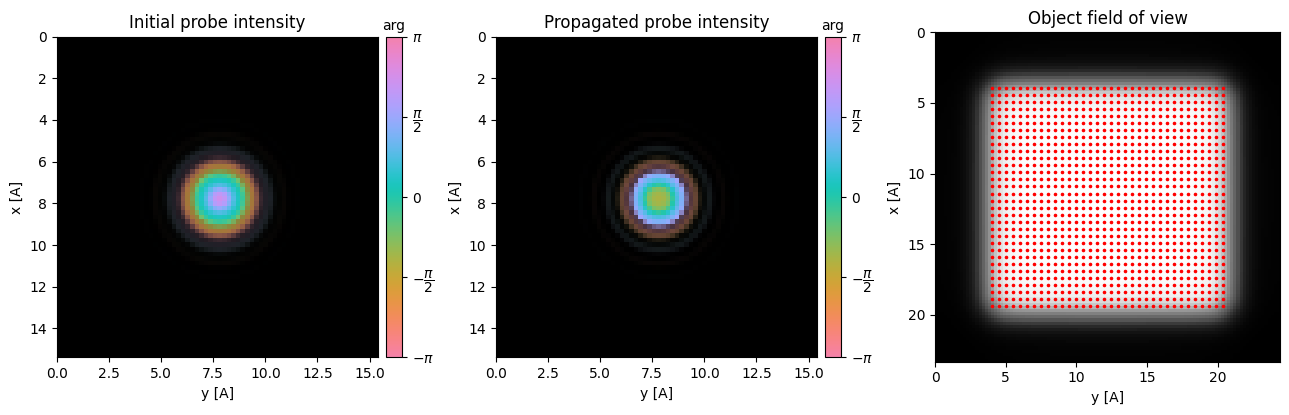

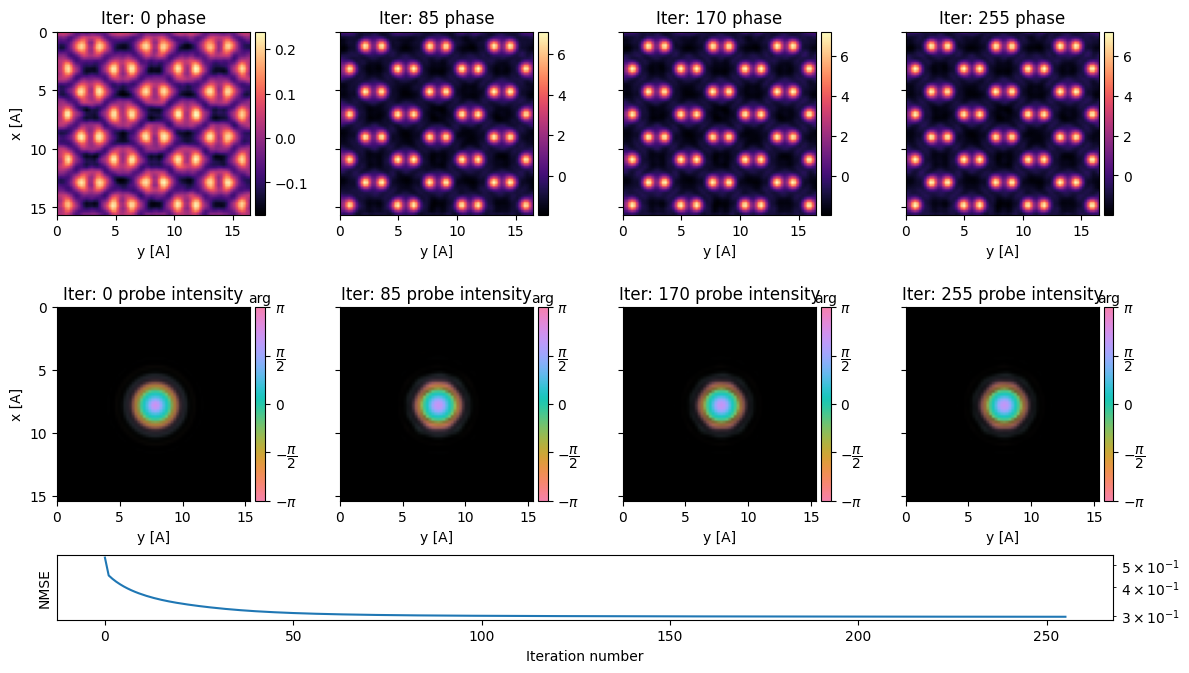

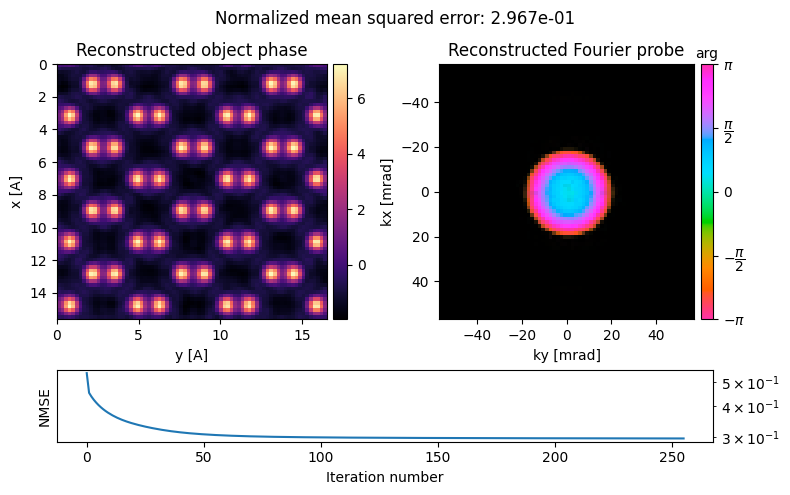

In [ ]:

############################### Import libraries ###############################

import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from collections import namedtuple
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import py4DSTEM
print(py4DSTEM.__version__)


############################### Import Initial Dataset ###############################

dataset =  py4DSTEM.read("ptycho_Si-110_18nm.h5")
dataset.calibration





############################### Expert params ###############################

semiangle_cutoff      = 20
defocus               = 100
energy                = 200e3
max_iter              = 256
step_size             = 0.175
identical_slices_iter = 256
slice_thicknesses     = 30.794230884706234
num_slices            = 6


ms_ptycho_18nm = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
    datacube=dataset,
    num_slices=num_slices,
    slice_thicknesses=slice_thicknesses,
    verbose=True,
    energy=energy,
    defocus=defocus,
    semiangle_cutoff=semiangle_cutoff,
    object_padding_px=(18,18),
    device='gpu',
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
)

ms_ptycho_18nm = ms_ptycho_18nm.reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = max_iter,
    identical_slices_iter= identical_slices_iter,
    step_size=step_size ,
).visualize(
    iterations_grid = 'auto',
)
ms_ptycho_18nm._visualize_last_iteration(
    fig=None,
    cbar=True,
    plot_convergence=True,
    plot_probe=True,
    plot_fourier_probe=True,
    padding=0,
)

ms_ptycho_18nm.error
print('NMSE of Expert params:',ms_ptycho_18nm.error)



In [ ]:


############################### Set Paramaters ###############################

weight_ratio = 0.5 # exploration weight = weight_ratio * max(score)

# 8 parameters to optimize, here are the ranges of these params
semiangle_cutoff = np.arange(1, 30.1, 0.1).round(1)
defocus          = np.arange(1, 201, 1).round(0)
energy           = np.arange(1e3, 300e3, 1000).round(0)
max_iter         = np.round(np.arange(1, 21, 1))
step_size        = np.arange(0.01,1,0.01).round(2)
identical_slices_iter = np.round(np.arange(1, 500, 1))
slice_thicknesses     = np.arange(1,50,0.1).round(1)
num_slices       = np.round(np.arange(1, 101, 1))

all_para = [semiangle_cutoff,
            defocus,
            energy,
            max_iter,
            step_size ,
            identical_slices_iter,
            slice_thicknesses,
            num_slices]



################################ reconstruction using py4stem ###############################


def oracle(x): # reconstruction and calculate the NMSE value using py4stem
    semiangle_cutoff = x[0]
    defocus          = x[1]
    energy           = x[2]
    max_iter         = x[3]
    step_size        = x[4]
    identical_slices_iter = x[5]
    slice_thicknesses     = x[6]
    num_slices       = x[7]

    ms_ptycho_18nm = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
        datacube=dataset,
        num_slices=round(num_slices),
        slice_thicknesses=slice_thicknesses,
        verbose=True,
        energy=energy,
        defocus=defocus,
        semiangle_cutoff=semiangle_cutoff,
        object_padding_px=(18,18),
        device='gpu',
    ).preprocess(
        plot_center_of_mass = False,
        plot_rotation=False,
    )
    plt.close()
    ms_ptycho_18nm = ms_ptycho_18nm.reconstruct(
        reset=True,
        store_iterations=True,
        max_iter = round(max_iter),
        identical_slices_iter= round(identical_slices_iter),
        step_size=step_size,
    ).visualize(
        iterations_grid = 'auto',
    )

    plt.close()
    print(ms_ptycho_18nm.error)
    return ms_ptycho_18nm.error

def value_cal(x):
    value=oracle(x)
    return 1/value , value

def oracle_show(x): # reconstruction and visulization using py4stem
    semiangle_cutoff = x[0]
    defocus          = x[1]
    # rotation_degrees = x[2]
    energy           = x[2]
    max_iter         = x[3]
    step_size        = x[4]
    identical_slices_iter = x[5]
    slice_thicknesses     = x[6]
    num_slices       = x[7]

    ms_ptycho_18nm = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
        datacube=dataset,
        num_slices=round(num_slices),
        slice_thicknesses=slice_thicknesses,
        verbose=True,
        energy=energy,
        defocus=defocus,
        semiangle_cutoff=semiangle_cutoff,
        object_padding_px=(18,18),
        device='gpu',
    ).preprocess(
        plot_center_of_mass = False,
        plot_rotation=False,
    )
    # plt.close()
    ms_ptycho_18nm = ms_ptycho_18nm.reconstruct(
        reset=True,
        store_iterations=True,
        max_iter = round(max_iter),
        identical_slices_iter= round(identical_slices_iter),
        step_size=step_size,
    ).visualize(
        iterations_grid = 'auto',
    )

    ms_ptycho_18nm._visualize_last_iteration(
        fig=None,
        cbar=True,
        plot_convergence=True,
        plot_probe=True,
        plot_fourier_probe=True,
        padding=0,
    )

    print(ms_ptycho_18nm.error)
    return ms_ptycho_18nm.error





############################### Generate 20 initial points ###############################

n_dim = len(all_para)
num_initial = 20 # number of initial points
para1 = np.random.choice(semiangle_cutoff,num_initial)
para2 = np.random.choice(defocus,num_initial)
para4 = np.random.choice(energy,num_initial)
para5 = np.random.choice(max_iter,num_initial)
para6 = np.random.choice(step_size,num_initial)
para7 = np.random.choice(identical_slices_iter,num_initial)
para8 = np.random.choice(slice_thicknesses,num_initial)
para9 = np.random.choice(num_slices,num_initial)


initial_points = np.concatenate(([para1],
                                  [para2],
                                  [para4],
                                   [para5],
                                  [para6],
                                  [para7],
                                  [para8],
                                  [para9]),axis=0).T
initial_values = []
for i in initial_points:
    print(i)
    initial_value = oracle(i)
    initial_values.append(initial_value)
initial_values = np.array(initial_values)
initial_point = initial_points[np.argmin(initial_values)].reshape(-1)
df = pd.DataFrame(np.concatenate((initial_points,initial_values.reshape(-1,1)),axis=1))
df.columns= ['semiangle_cutoff',
              'defocus',
              'energy',
               'max_iter',
              'step_size',
              'identical_slices_iter',
                'slice_thicknesses',
              'num_slices',
              'NMSE']
df.to_csv('initial.csv')



[2.00e+01 7.80e+01 2.40e+04 7.00e+00 4.60e-01 3.07e+02 1.28e+01 7.00e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 7/7 [00:01<00:00,  3.50 iter/s]


0.5787842273712158
[1.51e+01 1.60e+01 1.50e+04 1.40e+01 9.30e-01 4.57e+02 4.20e+00 9.90e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 14/14 [00:05<00:00,  2.67 iter/s]


0.6204124689102173
[2.85e+01 3.60e+01 2.01e+05 1.20e+01 7.20e-01 9.60e+01 4.76e+01 3.90e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 12/12 [00:01<00:00,  6.68 iter/s]


0.8380441069602966
[6.50e+00 1.92e+02 1.56e+05 8.00e+00 9.20e-01 2.38e+02 1.49e+01 3.30e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 8/8 [00:01<00:00,  7.63 iter/s]


0.5887622237205505
[7.20e+00 1.90e+02 2.98e+05 1.80e+01 3.20e-01 4.00e+00 1.47e+01 2.50e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 10.25 iter/s]


0.6350293159484863
[1.46e+01 1.60e+01 1.95e+05 1.30e+01 7.00e-02 8.60e+01 4.91e+01 9.00e+00]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 13/13 [00:00<00:00, 26.80 iter/s]


0.540757417678833
[1.41e+01 8.60e+01 1.78e+05 1.00e+00 1.20e-01 2.40e+01 1.54e+01 4.10e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 1 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 1/1 [00:00<00:00,  6.13 iter/s]


0.9125921130180359
[2.29e+01 1.23e+02 2.00e+03 6.00e+00 8.70e-01 3.90e+02 6.40e+00 8.70e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 6 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 6/6 [00:01<00:00,  3.03 iter/s]


0.6216948628425598
[2.76e+01 9.80e+01 1.17e+05 1.30e+01 8.00e-02 4.41e+02 3.43e+01 1.00e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 13/13 [00:00<00:00, 22.24 iter/s]


0.49496349692344666
[2.00e+01 1.93e+02 5.10e+04 9.00e+00 2.00e-02 1.07e+02 4.23e+01 4.70e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 9 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 9/9 [00:01<00:00,  5.43 iter/s]


0.46332287788391113
[2.50e+00 2.70e+01 9.50e+04 1.70e+01 2.90e-01 4.26e+02 8.80e+00 1.90e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 13.42 iter/s]


0.5663043260574341
[7.40e+00 1.07e+02 2.28e+05 2.00e+00 6.00e-01 3.59e+02 3.71e+01 3.80e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 2 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 2/2 [00:00<00:00,  6.59 iter/s]


0.9973771572113037
[1.21e+01 1.17e+02 8.00e+04 1.00e+00 3.10e-01 2.95e+02 2.95e+01 1.90e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 1 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 1/1 [00:00<00:00, 12.00 iter/s]


1.077019214630127
[2.69e+01 2.90e+01 1.00e+04 1.40e+01 8.20e-01 1.41e+02 1.58e+01 8.00e+00]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 14/14 [00:00<00:00, 29.67 iter/s]


0.5737759470939636
[1.93e+01 1.63e+02 2.87e+05 8.00e+00 2.80e-01 2.10e+02 5.50e+00 2.00e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.62 iter/s]


0.4121471345424652
[1.44e+01 1.88e+02 2.48e+05 7.00e+00 7.60e-01 3.46e+02 4.36e+01 2.00e+00]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 85.80 iter/s]


0.4372182786464691
[2.20e+00 1.99e+02 1.06e+05 3.00e+00 8.00e-01 9.00e+01 2.47e+01 3.20e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 3/3 [00:00<00:00,  8.07 iter/s]


0.9416421055793762
[5.60e+00 1.25e+02 2.77e+05 1.40e+01 3.10e-01 1.13e+02 2.72e+01 3.30e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00,  7.45 iter/s]


0.7775574326515198
[1.17e+01 5.90e+01 1.31e+05 3.00e+00 1.00e-01 3.27e+02 3.47e+01 5.60e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 3/3 [00:00<00:00,  4.57 iter/s]


0.8179069757461548
[2.97e+01 1.62e+02 2.34e+05 2.00e+01 2.90e-01 2.30e+01 1.40e+01 7.90e+01]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 20/20 [00:06<00:00,  3.32 iter/s]


0.7869499921798706


In [ ]:



################################# End of Part I ################################




################################################################################
> # **Part - II**

*   Define the DANTE alghorithm

################################################################################

In [ ]:
################################# DANTE alghorithm ################################


class DANTE:
    def __init__(self, exploration_weight=1):
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node."
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        def score(n):
            if self.N[n] == 0:
               return '-inf'  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward
        def evaluate(n):
            return n.value  # average reward
        log_N_vertex = math.log(self.N[node])
        def uct(n):
            "Upper confidence bound for trees"
            uct_value = n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n]+1))
            return uct_value

        media_node = max(self.children[node], key=uct)#self._uct_select(node)
        print(f'number of visit is {self.N[media_node]}')
        print(f'uct media node : {media_node}')
        print(f'uct of the node is{uct(media_node)} ')
        if uct(media_node) > uct(node):
            # print(f'number of visit is {self.N[media_node]}')
            # print(f'better uct media node : {media_node}')
            # print(f'uct of the node is{uct(media_node)} ')
            return media_node
        return node

    def do_rollout(self, node):
        """Make the tree one layer better. (Train for one iteration.)"""
        self._expand(node)
        self._backpropagate(path=node)

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        action = [p for p in range(0, len(node.tup))]
        self.children[node] = node.find_children(action)

    def _backpropagate(self, path):
        """Send the reward back up to the ancestors of the leaf"""
        self.N[path] += 1
        
class Node(ABC):
    """
    A representation of a single board state.
    DANTE works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """
    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

    @abstractmethod
    def __hash__(self):
        "Nodes must be hashable"
        return 123456789

    @abstractmethod
    def __eq__(node1, node2):
        "Nodes must be comparable"
        return True

_OT = namedtuple("opt_task", "tup value terminal")

# Inheriting from a namedtuple is convenient because it makes the class
# immutable and predefines __init__, __repr__, __hash__, __eq__, and others
class opt_task(_OT, Node):

    def find_children(board,action):
        if board.terminal:  # If the game is finished then no moves can be made
            return set()
        return {
            board.make_move(i) for i in action}

    def is_terminal(board):
        return board.terminal

    ############################ design the action space ############################

    def make_move(board, index):
        print(index)
        tup = list(board.tup)
        flip = np.random.randint(0,6)
        if flip ==0:
            indices = np.where(all_para[index]==tup[index])[0][0]
            try:
                tup[index] = all_para[index][indices+1]
            except:
                tup[index] = all_para[index][indices-1]

        elif flip ==1:
            indices = np.where(all_para[index]==tup[index])[0][0]
            try:
                tup[index] = all_para[index][indices-1]
            except:
                tup[index] = all_para[index][indices+1]

        elif flip ==2:
            n_flip = np.random.choice(np.arange(n_dim),int(n_dim/3),replace=False)
            for i in n_flip:
                tup[i] = np.random.choice(all_para[i],1)[0]

        elif flip ==3:
            n_flip = np.random.choice(np.arange(n_dim),int(n_dim/2),replace=False)
            for i in n_flip:
                tup[i] = np.random.choice(all_para[i],1)[0]

        else:
            tup[index] = np.random.choice(all_para[index],1)[0]

        tup[index] = round(tup[index],2)
        print(tup)
        value,ture_value = value_cal(tup)
        print('ptycho.error:',ture_value)
        is_terminal = False
        return opt_task(tuple(tup), value, is_terminal)


In [ ]:




################################ End of Part II ################################






################################################################################
> # **Part - III**

*   Optimization using DANTE

################################################################################


Input description:
*   initial_point: initial node for DANTE

Output description:

*   all_input: newly sampled data
*   all_value: NMSE of sampled data


In [ ]:
################################ Optimization using DANTE ###############################

# Initialization
x_current = np.round(initial_point,5)
x = tuple(x_current)
values, cu_Y = value_cal(x)
exploration_weight = weight_ratio*values
board_ubt = opt_task(tup = x, value = values, terminal = False)
tree_ubt = DANTE(exploration_weight = exploration_weight)

# Optimization start
print('start...')
sign1 = 0 #Determine whether convergence
all_value=list([cu_Y])
all_input=list([x_current])
print('ptycho.error:',cu_Y)
for i in tqdm(range(0, 500, 1)):
   print('iteration:',i)
   tree_ubt.do_rollout(board_ubt)
   board_ubt = tree_ubt.choose(board_ubt)
   value_new = board_ubt.value
   temp_Y    = 1/value_new

   if temp_Y<cu_Y:
       cu_Y=float(temp_Y)
       x_current = np.array(board_ubt.tup)
       exploration_weight=weight_ratio*value_new
       tree_ubt = DANTE(exploration_weight=exploration_weight)
       print('current best ptycho.error:',cu_Y)

   all_value.append(cu_Y)
   all_input.append(x_current)

   df2 = pd.DataFrame(np.concatenate((np.array(all_input),np.array(all_value).reshape(-1,1)),axis=1))
   df2.columns= ['semiangle_cutoff',
                 'defocus',
                 'energy',
                  'max_iter',
                 'step_size',
                 'identical_slices_iter',
                 'slice_thicknesses',
                 'num_slices',
                 'NMSE']
   df2.to_csv('results-DANTE.csv')


   if round(cu_Y,10)==0:
        sign1=1
        break
print('final value:',cu_Y)
print('completed!')



Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.53 iter/s]


0.4121471643447876
start...
ptycho.error: 0.4121471643447876


  0%|          | 0/500 [00:00<?, ?it/s]

iteration: 0
0
[7.0, 163.0, 287000.0, 8.0, 0.28, 210.0, 5.5, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.31 iter/s]


0.6974589824676514
ptycho.error: 0.6974589824676514
1
[14.2, 163.0, 80000.0, 8.0, 0.28, 210.0, 47.5, 100]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:03<00:00,  2.59 iter/s]


0.6408103704452515
ptycho.error: 0.6408103704452515
2
[19.3, 163.0, 286000.0, 8.0, 0.28, 210.0, 5.5, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.16 iter/s]


0.41205140948295593
ptycho.error: 0.41205140948295593
3
[20.0, 170, 25000.0, 8.0, 0.28, 274, 5.5, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.43 iter/s]


0.5503643155097961
ptycho.error: 0.5503643155097961
4
[19.3, 163.0, 287000.0, 8.0, 0.29, 210.0, 5.5, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.03 iter/s]


0.41172727942466736
ptycho.error: 0.41172727942466736
5
[19.3, 99, 287000.0, 8.0, 0.28, 210.0, 5.5, 3]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 54.89 iter/s]


0.4171668291091919
ptycho.error: 0.4171668291091919
6
[19.3, 163.0, 287000.0, 8.0, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.22 iter/s]


0.4115126132965088
ptycho.error: 0.4115126132965088
7
[19.3, 163.0, 22000.0, 8.0, 0.28, 210.0, 35.0, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  0%|          | 1/500 [00:11<1:39:13, 11.93s/it]

0.5424452424049377
ptycho.error: 0.5424452424049377
number of visit is 0
uct media node : opt_task(tup=(19.3, 163.0, 287000.0, 8.0, 0.28, 210.0, 7.7, 20.0), value=2.430059171186245, terminal=False)
uct of the node is2.430059171186245 
current best ptycho.error: 0.4115126132965088
iteration: 1
0
[19.3, 24, 194000.0, 8.0, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 11.99 iter/s]


0.4626271724700928
ptycho.error: 0.4626271724700928
1
[19.3, 18, 287000.0, 8.0, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.39 iter/s]


0.48844054341316223
ptycho.error: 0.48844054341316223
2
[7.7, 163.0, 287000.0, 10, 0.28, 274, 7.7, 41]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 10 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 10/10 [00:01<00:00,  6.15 iter/s]


0.7250024080276489
ptycho.error: 0.7250024080276489
3
[19.3, 163.0, 287000.0, 7, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.07 iter/s]


0.41359496116638184
ptycho.error: 0.41359496116638184
4
[19.3, 163.0, 287000.0, 8.0, 0.21, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.35 iter/s]


0.41507548093795776
ptycho.error: 0.41507548093795776
5
[28.2, 163.0, 287000.0, 8.0, 0.37, 149, 7.7, 2]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 74.37 iter/s]


0.4441390931606293
ptycho.error: 0.4441390931606293
6
[19.3, 163.0, 287000.0, 8.0, 0.4, 210.0, 7.7, 87]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:02<00:00,  2.89 iter/s]


0.6808069944381714
ptycho.error: 0.6808069944381714
7
[19.3, 163.0, 287000.0, 8.0, 0.28, 210.0, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  0%|          | 2/500 [00:24<1:43:48, 12.51s/it]

0.41178807616233826
ptycho.error: 0.41178807616233826
number of visit is 0
uct media node : opt_task(tup=(19.3, 163.0, 287000.0, 8.0, 0.28, 210.0, 7.7, 21), value=2.428433599436649, terminal=False)
uct of the node is2.428433599436649 
iteration: 2
0
[25.0, 163.0, 287000.0, 8.0, 0.28, 210.0, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 11.25 iter/s]


0.41994649171829224
ptycho.error: 0.41994649171829224
1
[19.3, 18, 287000.0, 8.0, 0.28, 210.0, 7.7, 47]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:01<00:00,  5.17 iter/s]


0.4718492925167084
ptycho.error: 0.4718492925167084
2
[19.3, 163.0, 57000.0, 8.0, 0.28, 210.0, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 11.71 iter/s]


0.51919025182724
ptycho.error: 0.51919025182724
3
[19.3, 163.0, 287000.0, 9, 0.28, 210.0, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 9 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 9/9 [00:00<00:00, 11.76 iter/s]


0.4101269543170929
ptycho.error: 0.4101269543170929
4
[19.3, 163.0, 287000.0, 8.0, 0.27, 210.0, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 11.89 iter/s]


0.41217929124832153
ptycho.error: 0.41217929124832153
5
[19.3, 163.0, 154000.0, 8.0, 0.28, 210.0, 21.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 11.85 iter/s]


0.5706014037132263
ptycho.error: 0.5706014037132263
6
[19.3, 163.0, 287000.0, 8.0, 0.28, 210.0, 7.6, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 11.58 iter/s]


0.41164880990982056
ptycho.error: 0.41164880990982056
7
[16.5, 163.0, 14000.0, 3, 0.68, 210.0, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  1%|          | 3/500 [00:35<1:36:58, 11.71s/it]

0.7436573505401611
ptycho.error: 0.7436573505401611
number of visit is 0
uct media node : opt_task(tup=(19.3, 163.0, 287000.0, 7, 0.28, 210.0, 7.7, 20.0), value=2.4178244270188727, terminal=False)
uct of the node is3.429402911197453 
iteration: 3
0
[19.4, 163.0, 287000.0, 7, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.56 iter/s]


0.4128452241420746
ptycho.error: 0.4128452241420746
1
[19.3, 74, 287000.0, 7, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.74 iter/s]


0.3640330135822296
ptycho.error: 0.3640330135822296
2
[19.3, 163.0, 293000.0, 7, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.76 iter/s]


0.4133739471435547
ptycho.error: 0.4133739471435547
3
[24.3, 163.0, 287000.0, 7, 0.28, 406, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.04 iter/s]


0.4215224087238312
ptycho.error: 0.4215224087238312
4
[19.3, 163.0, 287000.0, 7, 0.27, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 11.88 iter/s]


0.4140172302722931
ptycho.error: 0.4140172302722931
5
[19.3, 163.0, 287000.0, 7, 0.28, 209, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 11.95 iter/s]


0.4135949909687042
ptycho.error: 0.4135949909687042
6
[19.3, 163.0, 287000.0, 7, 0.28, 210.0, 29.8, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 11.76 iter/s]


0.47006306052207947
ptycho.error: 0.47006306052207947
7
[19.3, 163.0, 287000.0, 7, 0.28, 210.0, 7.7, 70]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  1%|          | 4/500 [00:46<1:33:53, 11.36s/it]

0.508011519908905
ptycho.error: 0.508011519908905
number of visit is 0
uct media node : opt_task(tup=(19.3, 74, 287000.0, 7, 0.28, 210.0, 7.7, 20.0), value=2.7470036032160996, terminal=False)
uct of the node is2.7470036032160996 
current best ptycho.error: 0.3640330135822296
iteration: 4
0
[19.2, 74, 287000.0, 7, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 11.88 iter/s]


0.36428549885749817
ptycho.error: 0.36428549885749817
1
[19.3, 74, 287000.0, 15, 0.28, 210.0, 7.7, 39]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:02<00:00,  6.16 iter/s]


0.42940250039100647
ptycho.error: 0.42940250039100647
2
[14.7, 154, 287000.0, 7, 0.41, 210.0, 33.4, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 11.69 iter/s]


0.4737706482410431
ptycho.error: 0.4737706482410431
3
[19.3, 74, 287000.0, 15, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.70 iter/s]


0.34938231110572815
ptycho.error: 0.34938231110572815
4
[19.3, 32, 287000.0, 16, 0.28, 251, 7.7, 64]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:03<00:00,  4.03 iter/s]


0.4977119565010071
ptycho.error: 0.4977119565010071
5
[19.3, 74, 287000.0, 7, 0.28, 209, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.41 iter/s]


0.3640330135822296
ptycho.error: 0.3640330135822296
6
[19.3, 74, 287000.0, 7, 0.28, 210.0, 7.8, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.61 iter/s]


0.3633132576942444
ptycho.error: 0.3633132576942444
7
[15.1, 74, 24000.0, 7, 0.28, 151, 13.0, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  1%|          | 5/500 [01:02<1:46:56, 12.96s/it]

0.48226407170295715
ptycho.error: 0.48226407170295715
number of visit is 0
uct media node : opt_task(tup=(19.3, 74, 287000.0, 15, 0.28, 210.0, 7.7, 20.0), value=2.8621941300782843, terminal=False)
uct of the node is2.8621941300782843 
current best ptycho.error: 0.34938231110572815
iteration: 5
0
[9.2, 74, 287000.0, 15, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.78 iter/s]


0.5869980454444885
ptycho.error: 0.5869980454444885
1
[19.3, 51, 287000.0, 15, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.41 iter/s]


0.367114394903183
ptycho.error: 0.367114394903183
2
[19.3, 74, 286000.0, 15, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.34903931617736816
ptycho.error: 0.34903931617736816
3
[19.3, 12, 19000.0, 15, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.73 iter/s]


0.46200719475746155
ptycho.error: 0.46200719475746155
4
[19.3, 74, 287000.0, 15, 0.43, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.77 iter/s]


0.3611440360546112
ptycho.error: 0.3611440360546112
5
[19.3, 74, 287000.0, 15, 0.28, 211, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.68 iter/s]


0.34938228130340576
ptycho.error: 0.34938228130340576
6
[19.3, 74, 287000.0, 15, 0.28, 210.0, 11.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.79 iter/s]


0.39364323019981384
ptycho.error: 0.39364323019981384
7
[19.3, 74, 287000.0, 15, 0.28, 210.0, 7.7, 94]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  1%|          | 6/500 [01:21<2:03:47, 15.03s/it]

0.5109752416610718
ptycho.error: 0.5109752416610718
number of visit is 0
uct media node : opt_task(tup=(19.3, 74, 286000.0, 15, 0.28, 210.0, 7.7, 20.0), value=2.8650067589859676, terminal=False)
uct of the node is2.8650067589859676 
current best ptycho.error: 0.34903931617736816
iteration: 6
0
[19.4, 74, 286000.0, 15, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.71 iter/s]


0.3492680788040161
ptycho.error: 0.3492680788040161
1
[15.0, 74, 286000.0, 15, 0.28, 171, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.85 iter/s]


0.43224167823791504
ptycho.error: 0.43224167823791504
2
[11.3, 74, 80000.0, 18, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 12.73 iter/s]


0.4872352182865143
ptycho.error: 0.4872352182865143
3
[29.8, 2, 286000.0, 15, 0.28, 191, 5.4, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.75 iter/s]


0.3855815529823303
ptycho.error: 0.3855815529823303
4
[16.4, 74, 244000.0, 15, 0.28, 210.0, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.81 iter/s]


0.3869580030441284
ptycho.error: 0.3869580030441284
5
[19.3, 74, 286000.0, 15, 0.28, 32, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.77 iter/s]


0.3490392863750458
ptycho.error: 0.3490392863750458
6
[19.3, 74, 286000.0, 15, 0.28, 210.0, 43.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.66 iter/s]


0.4591674208641052
ptycho.error: 0.4591674208641052
7
[19.3, 74, 286000.0, 18, 0.28, 252, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  1%|▏         | 7/500 [01:36<2:04:36, 15.17s/it]

0.382826566696167
ptycho.error: 0.382826566696167
number of visit is 0
uct media node : opt_task(tup=(19.3, 74, 286000.0, 15, 0.28, 32, 7.7, 20.0), value=2.8650070036113107, terminal=False)
uct of the node is2.8650070036113107 
current best ptycho.error: 0.3490392863750458
iteration: 7
0
[19.4, 74, 286000.0, 15, 0.28, 32, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.69 iter/s]


0.3492681086063385
ptycho.error: 0.3492681086063385
1
[19.3, 53, 286000.0, 15, 0.28, 32, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.73 iter/s]


0.36500972509384155
ptycho.error: 0.36500972509384155
2
[19.3, 74, 286000.0, 15, 0.28, 470, 24.9, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.77 iter/s]


0.44976261258125305
ptycho.error: 0.44976261258125305
3
[19.3, 74, 286000.0, 20, 0.28, 32, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.84 iter/s]


0.37791210412979126
ptycho.error: 0.37791210412979126
4
[19.3, 74, 286000.0, 15, 0.73, 32, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.39749711751937866
ptycho.error: 0.39749711751937866
5
[19.3, 74, 286000.0, 15, 0.28, 33, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.70 iter/s]


0.34903931617736816
ptycho.error: 0.34903931617736816
6
[19.3, 138, 286000.0, 16, 0.28, 32, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.70 iter/s]


0.38731855154037476
ptycho.error: 0.38731855154037476
7
[19.3, 74, 286000.0, 15, 0.28, 32, 7.7, 7]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  2%|▏         | 8/500 [01:50<2:00:27, 14.69s/it]

0.39308708906173706
ptycho.error: 0.39308708906173706
number of visit is 0
uct media node : opt_task(tup=(19.3, 74, 286000.0, 15, 0.28, 33, 7.7, 20.0), value=2.8650067589859676, terminal=False)
uct of the node is2.8650067589859676 
iteration: 8
0
[20.7, 74, 286000.0, 15, 0.28, 229, 1.3, 24]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 10.74 iter/s]


0.4510957598686218
ptycho.error: 0.4510957598686218
1
[19.3, 130, 286000.0, 15, 0.28, 33, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.72 iter/s]


0.46172595024108887
ptycho.error: 0.46172595024108887
2
[19.3, 74, 287000.0, 15, 0.28, 33, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.77 iter/s]


0.34938231110572815
ptycho.error: 0.34938231110572815
3
[19.3, 74, 286000.0, 11, 0.28, 33, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 11 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 11/11 [00:00<00:00, 12.82 iter/s]


0.35451236367225647
ptycho.error: 0.35451236367225647
4
[19.3, 74, 286000.0, 15, 0.62, 33, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.70 iter/s]


0.36995401978492737
ptycho.error: 0.36995401978492737
5
[19.3, 74, 286000.0, 15, 0.28, 32, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.34903931617736816
ptycho.error: 0.34903931617736816
6
[19.3, 74, 286000.0, 15, 0.28, 33, 7.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.74 iter/s]


0.3503166139125824
ptycho.error: 0.3503166139125824
7
[22.2, 64, 286000.0, 15, 0.28, 33, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  2%|▏         | 9/500 [02:05<2:01:13, 14.81s/it]

0.36389827728271484
ptycho.error: 0.36389827728271484
number of visit is 0
uct media node : opt_task(tup=(19.4, 74, 286000.0, 15, 0.28, 32, 7.7, 20.0), value=2.863130000589616, terminal=False)
uct of the node is4.055767396517464 
iteration: 9
0
[19.4, 74, 286000.0, 15, 0.28, 385, 7.7, 52]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:02<00:00,  5.02 iter/s]


0.4679184854030609
ptycho.error: 0.4679184854030609
1
[19.4, 64, 142000.0, 15, 0.28, 404, 7.7, 76]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:04<00:00,  3.50 iter/s]


0.4774208068847656
ptycho.error: 0.4774208068847656
2
[19.4, 74, 287000.0, 15, 0.28, 32, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.63 iter/s]


0.3496496379375458
ptycho.error: 0.3496496379375458
3
[19.4, 74, 286000.0, 16, 0.28, 32, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.62 iter/s]


0.3887954354286194
ptycho.error: 0.3887954354286194
4
[20.7, 52, 286000.0, 4, 0.28, 32, 30.9, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 4 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 4/4 [00:00<00:00, 12.54 iter/s]


0.5883235335350037
ptycho.error: 0.5883235335350037
5
[19.4, 74, 286000.0, 15, 0.28, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.79 iter/s]


0.3492680788040161
ptycho.error: 0.3492680788040161
6
[19.4, 74, 286000.0, 15, 0.28, 32, 7.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.63 iter/s]


0.35054922103881836
ptycho.error: 0.35054922103881836
7
[19.4, 23, 286000.0, 15, 0.28, 32, 17.1, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  2%|▏         | 10/500 [02:23<2:09:42, 15.88s/it]

0.4473648965358734
ptycho.error: 0.4473648965358734
number of visit is 0
uct media node : opt_task(tup=(19.4, 74, 286000.0, 15, 0.28, 338, 7.7, 20.0), value=2.863130244894574, terminal=False)
uct of the node is2.863130244894574 
iteration: 10
0
[19.4, 187, 52000.0, 7, 0.28, 291, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.58 iter/s]


0.448154479265213
ptycho.error: 0.448154479265213
1
[19.4, 75, 286000.0, 15, 0.28, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.65 iter/s]


0.3487820625305176
ptycho.error: 0.3487820625305176
2
[19.4, 126, 246000.0, 2, 0.28, 338, 46.2, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 2 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 2/2 [00:00<00:00, 12.16 iter/s]


0.6206694841384888
ptycho.error: 0.6206694841384888
3
[19.4, 74, 286000.0, 16, 0.28, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.68 iter/s]


0.388795405626297
ptycho.error: 0.388795405626297
4
[19.4, 74, 286000.0, 15, 0.29, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.67 iter/s]


0.3498605489730835
ptycho.error: 0.3498605489730835
5
[19.4, 74, 286000.0, 15, 0.28, 337, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.59 iter/s]


0.3492680788040161
ptycho.error: 0.3492680788040161
6
[19.4, 74, 286000.0, 15, 0.28, 338, 7.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.56 iter/s]


0.35054922103881836
ptycho.error: 0.35054922103881836
7
[19.4, 74, 286000.0, 15, 0.28, 338, 39.6, 4]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  2%|▏         | 11/500 [02:35<1:58:11, 14.50s/it]

0.3629848062992096
ptycho.error: 0.3629848062992096
number of visit is 0
uct media node : opt_task(tup=(19.4, 75, 286000.0, 15, 0.28, 338, 7.7, 20.0), value=2.867119922236547, terminal=False)
uct of the node is2.867119922236547 
current best ptycho.error: 0.3487820625305176
iteration: 11
0
[19.4, 75, 286000.0, 15, 0.28, 338, 35.5, 6]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:00<00:00, 38.09 iter/s]


0.36196643114089966
ptycho.error: 0.36196643114089966
1
[12.3, 184, 238000.0, 15, 0.28, 338, 7.7, 82]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:04<00:00,  3.24 iter/s]


0.6772841811180115
ptycho.error: 0.6772841811180115
2
[19.4, 75, 139000.0, 15, 0.28, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.3738332688808441
ptycho.error: 0.3738332688808441
3
[15.2, 75, 286000.0, 15, 0.28, 241, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.70 iter/s]


0.42784759402275085
ptycho.error: 0.42784759402275085
4
[19.4, 17, 66000.0, 15, 0.28, 204, 7.7, 33]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00,  7.80 iter/s]


0.46434274315834045
ptycho.error: 0.46434274315834045
5
[19.4, 75, 286000.0, 15, 0.28, 367, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.69 iter/s]


0.3487820625305176
ptycho.error: 0.3487820625305176
6
[19.4, 75, 286000.0, 15, 0.28, 338, 7.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.82 iter/s]


0.35022449493408203
ptycho.error: 0.35022449493408203
7
[15.8, 75, 286000.0, 18, 0.28, 476, 30.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  2%|▏         | 12/500 [02:54<2:09:45, 15.95s/it]

0.5252346992492676
ptycho.error: 0.5252346992492676
number of visit is 0
uct media node : opt_task(tup=(19.4, 75, 286000.0, 15, 0.28, 367, 7.7, 20.0), value=2.867119922236547, terminal=False)
uct of the node is2.867119922236547 
iteration: 12
0
[19.3, 75, 286000.0, 15, 0.28, 367, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.74 iter/s]


0.3486301600933075
ptycho.error: 0.3486301600933075
1
[19.4, 151, 286000.0, 15, 0.28, 367, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.69 iter/s]


0.3997509181499481
ptycho.error: 0.3997509181499481
2
[19.4, 75, 287000.0, 15, 0.28, 367, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.74 iter/s]


0.3492453694343567
ptycho.error: 0.3492453694343567
3
[19.4, 75, 286000.0, 16, 0.28, 367, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.75 iter/s]


0.38796117901802063
ptycho.error: 0.38796117901802063
4
[19.4, 75, 286000.0, 15, 0.27, 367, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.70 iter/s]


0.3482242226600647
ptycho.error: 0.3482242226600647
5
[19.4, 75, 286000.0, 15, 0.59, 367, 7.7, 32]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00,  8.08 iter/s]


0.42167460918426514
ptycho.error: 0.42167460918426514
6
[19.4, 75, 286000.0, 17, 0.28, 367, 13.5, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 12.91 iter/s]


0.4143151342868805
ptycho.error: 0.4143151342868805
7
[19.4, 75, 286000.0, 15, 0.28, 367, 7.7, 15]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  3%|▎         | 13/500 [03:08<2:06:09, 15.54s/it]

0.3768441379070282
ptycho.error: 0.3768441379070282
number of visit is 0
uct media node : opt_task(tup=(19.4, 75, 286000.0, 15, 0.28, 338, 7.6, 20.0), value=2.8553114201455734, terminal=False)
uct of the node is4.048828376145642 
iteration: 13
0
[1.6, 75, 286000.0, 15, 0.28, 338, 7.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.65 iter/s]


0.6253848671913147
ptycho.error: 0.6253848671913147
1
[19.4, 74, 286000.0, 15, 0.28, 338, 7.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.73 iter/s]


0.35054922103881836
ptycho.error: 0.35054922103881836
2
[19.4, 75, 287000.0, 15, 0.28, 338, 7.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.44 iter/s]


0.3505711853504181
ptycho.error: 0.3505711853504181
3
[19.4, 75, 286000.0, 4, 0.28, 338, 7.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 4 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 4/4 [00:00<00:00, 12.52 iter/s]


0.47897619009017944
ptycho.error: 0.47897619009017944
4
[1.3, 170, 286000.0, 15, 0.85, 443, 7.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.81 iter/s]


0.5695846080780029
ptycho.error: 0.5695846080780029
5
[19.4, 75, 75000.0, 15, 0.18, 338, 43.2, 37]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:02<00:00,  6.95 iter/s]


0.47451460361480713
ptycho.error: 0.47451460361480713
6
[19.4, 75, 286000.0, 15, 0.28, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.67 iter/s]


0.3487820625305176
ptycho.error: 0.3487820625305176
7
[19.4, 75, 286000.0, 15, 0.28, 338, 7.6, 84]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  3%|▎         | 14/500 [03:26<2:11:38, 16.25s/it]

0.7065290808677673
ptycho.error: 0.7065290808677673
number of visit is 2
uct media node : opt_task(tup=(19.4, 75, 286000.0, 15, 0.28, 338, 7.7, 20.0), value=2.867119922236547, terminal=False)
uct of the node is2.867119922236547 
iteration: 14
0
[22.4, 75, 286000.0, 15, 0.28, 338, 35.5, 6]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:00<00:00, 36.77 iter/s]


0.36284705996513367
ptycho.error: 0.36284705996513367
1
[19.4, 150, 286000.0, 15, 0.28, 338, 35.5, 6]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:00<00:00, 38.48 iter/s]


0.39683887362480164
ptycho.error: 0.39683887362480164
2
[4.3, 151, 286000.0, 4, 0.28, 338, 35.5, 86]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 4 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 4/4 [00:01<00:00,  3.08 iter/s]


0.9857498407363892
ptycho.error: 0.9857498407363892
3
[19.4, 75, 286000.0, 9, 0.28, 338, 35.5, 6]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 9 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 9/9 [00:00<00:00, 36.89 iter/s]


0.38037222623825073
ptycho.error: 0.38037222623825073
4
[19.4, 75, 42000.0, 8, 0.28, 366, 35.5, 9]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 26.88 iter/s]


0.4221285879611969
ptycho.error: 0.4221285879611969
5
[19.4, 176, 224000.0, 15, 0.28, 366, 35.5, 76]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:04<00:00,  3.50 iter/s]


0.45933496952056885
ptycho.error: 0.45933496952056885
6
[19.4, 75, 286000.0, 15, 0.28, 338, 35.4, 6]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:00<00:00, 37.42 iter/s]


0.3616357743740082
ptycho.error: 0.3616357743740082
7
[19.4, 75, 286000.0, 15, 0.28, 338, 35.5, 39]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  3%|▎         | 15/500 [03:42<2:10:40, 16.17s/it]

0.46464794874191284
ptycho.error: 0.46464794874191284
number of visit is 0
uct media node : opt_task(tup=(19.4, 75, 139000.0, 15, 0.28, 338, 7.7, 20.0), value=2.6749893154071867, terminal=False)
uct of the node is4.177570994011279 
iteration: 15
0
[19.4, 75, 139000.0, 4, 0.75, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 4 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 4/4 [00:00<00:00, 12.38 iter/s]


0.6499969363212585
ptycho.error: 0.6499969363212585
1
[19.4, 74, 139000.0, 15, 0.28, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.67 iter/s]


0.37373918294906616
ptycho.error: 0.37373918294906616
2
[29.9, 75, 139000.0, 15, 0.28, 338, 7.7, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 10.90 iter/s]


0.3807763457298279
ptycho.error: 0.3807763457298279
3
[19.4, 75, 139000.0, 16, 0.28, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.63 iter/s]


0.42596492171287537
ptycho.error: 0.42596492171287537
4
[19.4, 75, 139000.0, 15, 0.27, 338, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.81 iter/s]


0.37202155590057373
ptycho.error: 0.37202155590057373
5
[19.4, 75, 139000.0, 15, 0.28, 131, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.81 iter/s]


0.37383323907852173
ptycho.error: 0.37383323907852173
6
[19.4, 75, 139000.0, 15, 0.28, 338, 43.4, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.72 iter/s]


0.45745086669921875
ptycho.error: 0.45745086669921875
7
[19.4, 75, 226000.0, 15, 0.28, 190, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  3%|▎         | 16/500 [03:56<2:03:08, 15.26s/it]

0.33075976371765137
ptycho.error: 0.33075976371765137
number of visit is 0
uct media node : opt_task(tup=(19.4, 75, 226000.0, 15, 0.28, 190, 7.7, 20.0), value=3.0233423459983984, terminal=False)
uct of the node is3.0233423459983984 
current best ptycho.error: 0.33075976371765137
iteration: 16
0
[19.4, 75, 20000.0, 15, 0.28, 488, 48.5, 18]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 14.04 iter/s]


0.4665576219558716
ptycho.error: 0.4665576219558716
1
[19.4, 75, 226000.0, 15, 0.85, 147, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.75 iter/s]


0.5767711400985718
ptycho.error: 0.5767711400985718
2
[19.4, 75, 199000.0, 15, 0.28, 190, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.72 iter/s]


0.3324654698371887
ptycho.error: 0.3324654698371887
3
[19.4, 75, 226000.0, 14, 0.28, 190, 7.7, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 12.80 iter/s]


0.36378875374794006
ptycho.error: 0.36378875374794006
4
[19.4, 75, 190000.0, 8, 0.12, 190, 13.4, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.75 iter/s]


0.40271925926208496
ptycho.error: 0.40271925926208496
5
[19.4, 75, 226000.0, 15, 0.28, 133, 27.0, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.71 iter/s]


0.449453741312027
ptycho.error: 0.449453741312027
6
[19.4, 75, 226000.0, 15, 0.28, 190, 13.6, 20.0]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.83 iter/s]


0.41125673055648804
ptycho.error: 0.41125673055648804
7
[19.4, 75, 226000.0, 15, 0.28, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  3%|▎         | 17/500 [04:09<1:57:35, 14.61s/it]

0.32514628767967224
ptycho.error: 0.32514628767967224
number of visit is 0
uct media node : opt_task(tup=(19.4, 75, 226000.0, 15, 0.28, 190, 7.7, 21), value=3.0755387279253834, terminal=False)
uct of the node is3.0755387279253834 
current best ptycho.error: 0.32514628767967224
iteration: 17
0
[13.2, 75, 226000.0, 15, 0.28, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.16 iter/s]


0.4263012409210205
ptycho.error: 0.4263012409210205
1
[11.9, 75, 65000.0, 7, 0.28, 190, 4.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.08 iter/s]


0.5728649497032166
ptycho.error: 0.5728649497032166
2
[23.5, 75, 226000.0, 2, 0.28, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 2 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 2/2 [00:00<00:00, 11.73 iter/s]


0.780035138130188
ptycho.error: 0.780035138130188
3
[19.4, 75, 226000.0, 13, 0.28, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 13/13 [00:01<00:00, 12.10 iter/s]


0.3283444344997406
ptycho.error: 0.3283444344997406
4
[19.4, 75, 226000.0, 15, 0.27, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.08 iter/s]


0.3245532512664795
ptycho.error: 0.3245532512664795
5
[19.4, 75, 226000.0, 15, 0.28, 63, 10.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.11 iter/s]


0.3590685725212097
ptycho.error: 0.3590685725212097
6
[19.4, 75, 226000.0, 15, 0.28, 190, 26.4, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.20 iter/s]


0.4502526521682739
ptycho.error: 0.4502526521682739
7
[22.3, 76, 226000.0, 3, 0.61, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  4%|▎         | 18/500 [04:22<1:54:48, 14.29s/it]

0.611421525478363
ptycho.error: 0.611421525478363
number of visit is 0
uct media node : opt_task(tup=(19.4, 75, 226000.0, 15, 0.27, 190, 7.7, 21), value=3.0811584727553214, terminal=False)
uct of the node is3.0811584727553214 
current best ptycho.error: 0.3245532512664795
iteration: 18
0
[19.4, 75, 226000.0, 20, 0.27, 190, 7.7, 57]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:04<00:00,  4.63 iter/s]


0.8035587072372437
ptycho.error: 0.8035587072372437
1
[19.4, 76, 226000.0, 15, 0.27, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.09 iter/s]


0.3241327702999115
ptycho.error: 0.3241327702999115
2
[19.4, 75, 59000.0, 15, 0.27, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.24 iter/s]


0.4247046113014221
ptycho.error: 0.4247046113014221
3
[29.6, 75, 226000.0, 15, 0.01, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.22 iter/s]


0.652565598487854
ptycho.error: 0.652565598487854
4
[19.4, 75, 226000.0, 15, 0.68, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.23 iter/s]


0.3478701710700989
ptycho.error: 0.3478701710700989
5
[19.4, 75, 226000.0, 5, 0.27, 190, 6.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 5 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 5/5 [00:00<00:00, 11.97 iter/s]


0.37594860792160034
ptycho.error: 0.37594860792160034
6
[19.4, 75, 226000.0, 15, 0.27, 190, 16.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.16 iter/s]


0.4384476840496063
ptycho.error: 0.4384476840496063
7
[19.4, 183, 226000.0, 15, 0.27, 313, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  4%|▍         | 19/500 [04:39<2:00:13, 15.00s/it]

0.4039562940597534
ptycho.error: 0.4039562940597534
number of visit is 0
uct media node : opt_task(tup=(19.4, 76, 226000.0, 15, 0.27, 190, 7.7, 21), value=3.085155503020341, terminal=False)
uct of the node is3.085155503020341 
current best ptycho.error: 0.3241327702999115
iteration: 19
0
[11.7, 76, 226000.0, 15, 0.27, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.03 iter/s]


0.48565512895584106
ptycho.error: 0.48565512895584106
1
[16.5, 76, 245000.0, 19, 0.27, 270, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.15 iter/s]


0.3475762903690338
ptycho.error: 0.3475762903690338
2
[19.4, 76, 226000.0, 15, 0.52, 190, 7.7, 33]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00,  7.82 iter/s]


0.4825442433357239
ptycho.error: 0.4825442433357239
3
[19.4, 76, 226000.0, 16, 0.27, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.07 iter/s]


0.35058486461639404
ptycho.error: 0.35058486461639404
4
[19.4, 76, 226000.0, 15, 0.25, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.25 iter/s]


0.3232516944408417
ptycho.error: 0.3232516944408417
5
[19.4, 76, 226000.0, 15, 0.27, 481, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.11 iter/s]


0.3241327702999115
ptycho.error: 0.3241327702999115
6
[19.4, 76, 226000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.11 iter/s]


0.3229493796825409
ptycho.error: 0.3229493796825409
7
[19.4, 189, 226000.0, 15, 0.36, 190, 7.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  4%|▍         | 20/500 [04:54<2:01:21, 15.17s/it]

0.4011300504207611
ptycho.error: 0.4011300504207611
number of visit is 0
uct media node : opt_task(tup=(19.4, 76, 226000.0, 15, 0.27, 190, 7.8, 21), value=3.096460507163691, terminal=False)
uct of the node is3.096460507163691 
current best ptycho.error: 0.3229493796825409
iteration: 20
0
[19.3, 76, 226000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.10 iter/s]


0.3228020668029785
ptycho.error: 0.3228020668029785
1
[19.4, 75, 226000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.87 iter/s]


0.3234248459339142
ptycho.error: 0.3234248459339142
2
[19.4, 76, 225000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.06 iter/s]


0.3227551281452179
ptycho.error: 0.3227551281452179
3
[19.4, 141, 226000.0, 15, 0.27, 190, 30.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.98 iter/s]


0.45244333148002625
ptycho.error: 0.45244333148002625
4
[7.4, 76, 226000.0, 15, 0.27, 263, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.08 iter/s]


0.6012547016143799
ptycho.error: 0.6012547016143799
5
[19.4, 76, 227000.0, 14, 0.05, 190, 7.8, 29]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00,  8.86 iter/s]


0.3811729848384857
ptycho.error: 0.3811729848384857
6
[19.4, 76, 226000.0, 15, 0.27, 190, 6.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.98 iter/s]


0.3438588082790375
ptycho.error: 0.3438588082790375
7
[19.4, 76, 226000.0, 9, 0.27, 190, 24.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 9 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  4%|▍         | 21/500 [05:09<1:59:01, 14.91s/it]

0.45726191997528076
ptycho.error: 0.45726191997528076
number of visit is 0
uct media node : opt_task(tup=(19.4, 76, 225000.0, 15, 0.27, 190, 7.8, 21), value=3.098324125000635, terminal=False)
uct of the node is3.098324125000635 
current best ptycho.error: 0.3227551281452179
iteration: 21
0
[4.7, 174, 225000.0, 15, 0.27, 44, 43.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.93 iter/s]


0.6958611011505127
ptycho.error: 0.6958611011505127
1
[19.4, 75, 225000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.13 iter/s]


0.3232521414756775
ptycho.error: 0.3232521414756775
2
[19.4, 76, 225000.0, 14, 0.39, 389, 49.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 11.98 iter/s]


0.6017282605171204
ptycho.error: 0.6017282605171204
3
[13.1, 76, 225000.0, 15, 0.65, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.02 iter/s]


0.5734434723854065
ptycho.error: 0.5734434723854065
4
[16.3, 76, 19000.0, 15, 0.3, 190, 7.8, 62]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:03<00:00,  4.22 iter/s]


0.5231632590293884
ptycho.error: 0.5231632590293884
5
[19.4, 76, 225000.0, 15, 0.27, 189, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.04 iter/s]


0.3227551281452179
ptycho.error: 0.3227551281452179
6
[19.4, 76, 225000.0, 15, 0.27, 190, 44.6, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.72 iter/s]


0.459028959274292
ptycho.error: 0.459028959274292
7
[19.4, 76, 225000.0, 15, 0.27, 190, 7.8, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  4%|▍         | 22/500 [05:25<2:03:14, 15.47s/it]

0.32793664932250977
ptycho.error: 0.32793664932250977
number of visit is 0
uct media node : opt_task(tup=(19.4, 76, 225000.0, 15, 0.27, 189, 7.8, 21), value=3.098324125000635, terminal=False)
uct of the node is3.098324125000635 
iteration: 22
0
[19.3, 76, 225000.0, 15, 0.27, 189, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.09 iter/s]


0.3226318359375
ptycho.error: 0.3226318359375
1
[19.4, 75, 225000.0, 15, 0.27, 189, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.10 iter/s]


0.3232521116733551
ptycho.error: 0.3232521116733551
2
[19.4, 17, 225000.0, 15, 0.59, 256, 7.8, 5]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:00<00:00, 44.42 iter/s]


0.40103206038475037
ptycho.error: 0.40103206038475037
3
[9.9, 102, 225000.0, 15, 0.27, 189, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.17 iter/s]


0.5776444673538208
ptycho.error: 0.5776444673538208
4
[19.4, 76, 225000.0, 15, 0.8, 189, 7.8, 44]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:02<00:00,  5.92 iter/s]


0.7077376246452332
ptycho.error: 0.7077376246452332
5
[19.4, 76, 225000.0, 15, 0.57, 189, 7.8, 63]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:03<00:00,  4.20 iter/s]


0.5960838198661804
ptycho.error: 0.5960838198661804
6
[19.4, 169, 100000.0, 15, 0.27, 189, 29.8, 41]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:02<00:00,  6.31 iter/s]


0.4634431302547455
ptycho.error: 0.4634431302547455
7
[19.4, 76, 225000.0, 15, 0.27, 189, 7.8, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  5%|▍         | 23/500 [05:47<2:17:10, 17.26s/it]

0.3205224275588989
ptycho.error: 0.3205224275588989
number of visit is 0
uct media node : opt_task(tup=(19.4, 75, 225000.0, 15, 0.27, 190, 7.8, 21), value=3.0935603254935997, terminal=False)
uct of the node is4.383322344058809 
iteration: 23
0
[19.4, 53, 133000.0, 15, 0.15, 87, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.06 iter/s]


0.35686764121055603
ptycho.error: 0.35686764121055603
1
[19.4, 179, 225000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.23 iter/s]


0.4035240709781647
ptycho.error: 0.4035240709781647
2
[19.4, 75, 224000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.12 iter/s]


0.3231506645679474
ptycho.error: 0.3231506645679474
3
[19.4, 75, 225000.0, 18, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 12.10 iter/s]


0.34592047333717346
ptycho.error: 0.34592047333717346
4
[19.4, 75, 225000.0, 15, 0.76, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.12 iter/s]


0.48135852813720703
ptycho.error: 0.48135852813720703
5
[29.4, 75, 225000.0, 15, 0.27, 221, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.05 iter/s]


0.35442841053009033
ptycho.error: 0.35442841053009033
6
[19.4, 75, 225000.0, 15, 0.27, 190, 17.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.12 iter/s]


0.4400165379047394
ptycho.error: 0.4400165379047394
7
[19.4, 75, 225000.0, 15, 0.27, 190, 7.8, 72]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  5%|▍         | 24/500 [06:05<2:17:53, 17.38s/it]

0.5527873635292053
ptycho.error: 0.5527873635292053
number of visit is 0
uct media node : opt_task(tup=(19.4, 75, 224000.0, 15, 0.27, 190, 7.8, 21), value=3.094531776182483, terminal=False)
uct of the node is3.094531776182483 
iteration: 24
0
[6.7, 75, 76000.0, 15, 0.27, 423, 7.8, 86]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:04<00:00,  3.06 iter/s]


0.5642451643943787
ptycho.error: 0.5642451643943787
1
[13.3, 75, 224000.0, 10, 0.54, 131, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 10 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 10/10 [00:00<00:00, 12.16 iter/s]


0.5893754363059998
ptycho.error: 0.5893754363059998
2
[18.8, 89, 224000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.22 iter/s]


0.32111504673957825
ptycho.error: 0.32111504673957825
3
[19.4, 75, 224000.0, 20, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.16 iter/s]


0.34302642941474915
ptycho.error: 0.34302642941474915
4
[19.4, 75, 224000.0, 15, 0.23, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.97 iter/s]


0.3217073976993561
ptycho.error: 0.3217073976993561
5
[19.7, 91, 224000.0, 15, 0.71, 44, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.17 iter/s]


0.41320502758026123
ptycho.error: 0.41320502758026123
6
[29.6, 75, 266000.0, 16, 0.27, 190, 7.8, 7]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:00<00:00, 33.54 iter/s]


0.40180912613868713
ptycho.error: 0.40180912613868713
7
[19.4, 75, 224000.0, 15, 0.27, 190, 7.8, 94]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  5%|▌         | 25/500 [06:26<2:27:54, 18.68s/it]

0.47671806812286377
ptycho.error: 0.47671806812286377
number of visit is 0
uct media node : opt_task(tup=(18.8, 89, 224000.0, 15, 0.27, 190, 7.8, 21), value=3.114148683325301, terminal=False)
uct of the node is3.114148683325301 
current best ptycho.error: 0.32111504673957825
iteration: 25
0
[17.7, 13, 224000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.94 iter/s]


0.4091475307941437
ptycho.error: 0.4091475307941437
1
[18.8, 90, 224000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.10 iter/s]


0.32126909494400024
ptycho.error: 0.32126909494400024
2
[18.8, 89, 225000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.17 iter/s]


0.3211280405521393
ptycho.error: 0.3211280405521393
3
[18.8, 89, 224000.0, 15, 0.28, 190, 7.8, 15]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:00<00:00, 16.69 iter/s]


0.3784533739089966
ptycho.error: 0.3784533739089966
4
[26.5, 89, 247000.0, 15, 0.78, 288, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.05 iter/s]


0.5301135778427124
ptycho.error: 0.5301135778427124
5
[18.8, 99, 224000.0, 15, 0.1, 429, 7.8, 67]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:03<00:00,  3.94 iter/s]


0.4739847779273987
ptycho.error: 0.4739847779273987
6
[18.8, 89, 224000.0, 15, 0.27, 190, 31.5, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.07 iter/s]


0.45303475856781006
ptycho.error: 0.45303475856781006
7
[18.8, 135, 224000.0, 1, 0.89, 188, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 1 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  5%|▌         | 26/500 [06:42<2:20:04, 17.73s/it]

0.5876361727714539
ptycho.error: 0.5876361727714539
number of visit is 0
uct media node : opt_task(tup=(18.8, 89, 225000.0, 15, 0.27, 190, 7.8, 21), value=3.114022675443184, terminal=False)
uct of the node is3.114022675443184 
iteration: 26
0
[18.8, 26, 225000.0, 15, 0.27, 190, 7.8, 94]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:05<00:00,  2.81 iter/s]


0.5318965911865234
ptycho.error: 0.5318965911865234
1
[18.8, 89, 170000.0, 15, 0.27, 190, 42.5, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.99 iter/s]


0.45724761486053467
ptycho.error: 0.45724761486053467
2
[18.8, 89, 5000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.11 iter/s]


0.47225695848464966
ptycho.error: 0.47225695848464966
3
[18.8, 89, 225000.0, 16, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.17 iter/s]


0.34684720635414124
ptycho.error: 0.34684720635414124
4
[18.8, 89, 225000.0, 15, 0.17, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.92 iter/s]


0.3141572177410126
ptycho.error: 0.3141572177410126
5
[18.8, 89, 225000.0, 15, 0.27, 189, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.18 iter/s]


0.3211280405521393
ptycho.error: 0.3211280405521393
6
[18.8, 89, 225000.0, 15, 0.27, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.14 iter/s]


0.319661945104599
ptycho.error: 0.319661945104599
7
[19.3, 164, 225000.0, 15, 0.95, 190, 7.8, 75]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  5%|▌         | 27/500 [07:04<2:29:50, 19.01s/it]

0.6370739340782166
ptycho.error: 0.6370739340782166
number of visit is 0
uct media node : opt_task(tup=(18.8, 90, 224000.0, 15, 0.27, 190, 7.8, 21), value=3.112655452197504, terminal=False)
uct of the node is4.40900487526408 
iteration: 27
0
[1.4, 2, 224000.0, 5, 0.27, 298, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 5 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 5/5 [00:00<00:00, 11.97 iter/s]


0.7235453128814697
ptycho.error: 0.7235453128814697
1
[18.8, 89, 224000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.13 iter/s]


0.32111504673957825
ptycho.error: 0.32111504673957825
2
[18.8, 90, 223000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.13 iter/s]


0.3210813105106354
ptycho.error: 0.3210813105106354
3
[18.8, 90, 224000.0, 18, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 12.12 iter/s]


0.3432934284210205
ptycho.error: 0.3432934284210205
4
[18.8, 90, 224000.0, 15, 0.26, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.02 iter/s]


0.32069170475006104
ptycho.error: 0.32069170475006104
5
[18.8, 90, 224000.0, 10, 0.27, 190, 7.8, 28]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 10 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 10/10 [00:01<00:00,  8.93 iter/s]


0.4319244623184204
ptycho.error: 0.4319244623184204
6
[18.8, 187, 224000.0, 15, 0.27, 190, 25.3, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.94 iter/s]


0.45280998945236206
ptycho.error: 0.45280998945236206
7
[18.8, 90, 224000.0, 15, 0.27, 190, 7.8, 5]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  6%|▌         | 28/500 [07:17<2:14:58, 17.16s/it]

0.408145934343338
ptycho.error: 0.408145934343338
number of visit is 0
uct media node : opt_task(tup=(18.8, 90, 224000.0, 15, 0.26, 190, 7.8, 21), value=3.1182596406083363, terminal=False)
uct of the node is3.1182596406083363 
current best ptycho.error: 0.32069170475006104
iteration: 28
0
[18.9, 90, 224000.0, 15, 0.26, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.07 iter/s]


0.3206014037132263
ptycho.error: 0.3206014037132263
1
[18.8, 89, 224000.0, 15, 0.26, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.15 iter/s]


0.3205103278160095
ptycho.error: 0.3205103278160095
2
[18.8, 139, 224000.0, 15, 0.26, 190, 7.8, 1]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:00<00:00, 132.96 iter/s]


0.4295767545700073
ptycho.error: 0.4295767545700073
3
[20.7, 12, 224000.0, 19, 0.26, 190, 7.8, 43]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:03<00:00,  6.09 iter/s]


0.4619922935962677
ptycho.error: 0.4619922935962677
4
[18.8, 90, 224000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.14 iter/s]


0.32126903533935547
ptycho.error: 0.32126903533935547
5
[18.8, 90, 224000.0, 15, 0.26, 491, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.20 iter/s]


0.3206917643547058
ptycho.error: 0.3206917643547058
6
[18.8, 90, 224000.0, 15, 0.26, 190, 1.3, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.20 iter/s]


0.4378310739994049
ptycho.error: 0.4378310739994049
7
[18.8, 90, 224000.0, 6, 0.04, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 6 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  6%|▌         | 29/500 [07:35<2:16:40, 17.41s/it]

0.4392911195755005
ptycho.error: 0.4392911195755005
number of visit is 0
uct media node : opt_task(tup=(18.8, 89, 224000.0, 15, 0.26, 190, 7.8, 21), value=3.1200242650965517, terminal=False)
uct of the node is3.1200242650965517 
current best ptycho.error: 0.3205103278160095
iteration: 29
0
[9.4, 89, 32000.0, 6, 0.26, 190, 7.8, 27]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 6 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 6/6 [00:00<00:00,  9.19 iter/s]


0.5622915029525757
ptycho.error: 0.5622915029525757
1
[18.8, 90, 224000.0, 15, 0.26, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.24 iter/s]


0.3206917345523834
ptycho.error: 0.3206917345523834
2
[18.8, 89, 225000.0, 15, 0.26, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.24 iter/s]


0.3205282986164093
ptycho.error: 0.3205282986164093
3
[18.8, 89, 224000.0, 14, 0.26, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 12.17 iter/s]


0.34805727005004883
ptycho.error: 0.34805727005004883
4
[18.8, 89, 224000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.16 iter/s]


0.32111504673957825
ptycho.error: 0.32111504673957825
5
[18.8, 89, 224000.0, 15, 0.26, 189, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.01 iter/s]


0.3205103278160095
ptycho.error: 0.3205103278160095
6
[18.8, 89, 224000.0, 15, 0.26, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.99 iter/s]


0.31909918785095215
ptycho.error: 0.31909918785095215
7
[18.8, 91, 236000.0, 8, 0.26, 190, 35.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  6%|▌         | 30/500 [07:48<2:06:14, 16.12s/it]

0.5453161597251892
ptycho.error: 0.5453161597251892
number of visit is 0
uct media node : opt_task(tup=(18.8, 89, 224000.0, 15, 0.26, 190, 7.9, 21), value=3.1338218274221665, terminal=False)
uct of the node is3.1338218274221665 
current best ptycho.error: 0.31909918785095215
iteration: 30
0
[15.7, 89, 224000.0, 15, 0.26, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.16 iter/s]


0.3891238570213318
ptycho.error: 0.3891238570213318
1
[18.8, 52, 224000.0, 15, 0.26, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.12 iter/s]


0.3436938226222992
ptycho.error: 0.3436938226222992
2
[18.8, 89, 72000.0, 15, 0.26, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.00 iter/s]


0.41755592823028564
ptycho.error: 0.41755592823028564
3
[18.8, 89, 224000.0, 9, 0.78, 370, 33.4, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 9 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 9/9 [00:00<00:00, 12.24 iter/s]


0.4521319568157196
ptycho.error: 0.4521319568157196
4
[18.8, 89, 224000.0, 15, 0.27, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.33 iter/s]


0.31973493099212646
ptycho.error: 0.31973493099212646
5
[28.9, 80, 224000.0, 15, 0.26, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.21 iter/s]


0.35290756821632385
ptycho.error: 0.35290756821632385
6
[18.8, 89, 224000.0, 15, 0.26, 190, 38.3, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.20 iter/s]


0.4562229812145233
ptycho.error: 0.4562229812145233
7
[18.8, 89, 224000.0, 15, 0.26, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  6%|▌         | 31/500 [08:01<2:00:22, 15.40s/it]

0.3253852128982544
ptycho.error: 0.3253852128982544
number of visit is 0
uct media node : opt_task(tup=(18.8, 89, 224000.0, 15, 0.27, 190, 7.9, 21), value=3.1275907105208507, terminal=False)
uct of the node is3.1275907105208507 
iteration: 31
0
[18.7, 89, 224000.0, 15, 0.27, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.17 iter/s]


0.31968140602111816
ptycho.error: 0.31968140602111816
1
[18.8, 56, 224000.0, 15, 0.27, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.16 iter/s]


0.3379352390766144
ptycho.error: 0.3379352390766144
2
[18.8, 60, 203000.0, 15, 0.27, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.27 iter/s]


0.33083492517471313
ptycho.error: 0.33083492517471313
3
[18.8, 89, 239000.0, 15, 0.27, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.08 iter/s]


0.32259824872016907
ptycho.error: 0.32259824872016907
4
[18.8, 89, 224000.0, 15, 0.28, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.02 iter/s]


0.3204086720943451
ptycho.error: 0.3204086720943451
5
[18.8, 89, 224000.0, 15, 0.27, 191, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.25 iter/s]


0.31973493099212646
ptycho.error: 0.31973493099212646
6
[18.8, 89, 224000.0, 15, 0.27, 190, 7.8, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.13 iter/s]


0.32111501693725586
ptycho.error: 0.32111501693725586
7
[28.8, 89, 224000.0, 12, 0.27, 137, 7.9, 33]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  6%|▋         | 32/500 [08:16<1:58:24, 15.18s/it]

0.4756494462490082
ptycho.error: 0.4756494462490082
number of visit is 0
uct media node : opt_task(tup=(18.8, 89, 224000.0, 15, 0.26, 190, 7.9, 20), value=3.0732804084514216, terminal=False)
uct of the node is4.377819314934905 
iteration: 32
0
[18.7, 89, 224000.0, 15, 0.26, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.3252917528152466
ptycho.error: 0.3252917528152466
1
[18.8, 90, 224000.0, 15, 0.26, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.80 iter/s]


0.3256063163280487
ptycho.error: 0.3256063163280487
2
[18.8, 177, 224000.0, 15, 0.26, 190, 7.9, 33]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00,  7.82 iter/s]


0.5062840580940247
ptycho.error: 0.5062840580940247
3
[23.2, 120, 224000.0, 15, 0.26, 190, 7.9, 33]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00,  7.82 iter/s]


0.3599991202354431
ptycho.error: 0.3599991202354431
4
[18.8, 89, 224000.0, 15, 0.33, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.77 iter/s]


0.3328534960746765
ptycho.error: 0.3328534960746765
5
[16.2, 28, 224000.0, 6, 0.26, 190, 7.9, 24]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 6 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 6/6 [00:00<00:00, 10.70 iter/s]


0.5611475110054016
ptycho.error: 0.5611475110054016
6
[24.6, 82, 240000.0, 4, 0.26, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 4 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 4/4 [00:00<00:00, 12.42 iter/s]


0.48758435249328613
ptycho.error: 0.48758435249328613
7
[9.3, 1, 133000.0, 15, 0.78, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  7%|▋         | 33/500 [08:30<1:55:14, 14.81s/it]

0.5167791843414307
ptycho.error: 0.5167791843414307
number of visit is 0
uct media node : opt_task(tup=(18.7, 89, 224000.0, 15, 0.26, 190, 7.9, 20), value=3.0741633974592717, terminal=False)
uct of the node is3.0741633974592717 
iteration: 33
0
[18.6, 89, 224000.0, 15, 0.26, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.64 iter/s]


0.32552018761634827
ptycho.error: 0.32552018761634827
1
[18.7, 93, 224000.0, 15, 0.26, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.56 iter/s]


0.3263522982597351
ptycho.error: 0.3263522982597351
2
[18.7, 89, 223000.0, 15, 0.26, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.84 iter/s]


0.32524389028549194
ptycho.error: 0.32524389028549194
3
[18.7, 89, 224000.0, 16, 0.26, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.77 iter/s]


0.3422212302684784
ptycho.error: 0.3422212302684784
4
[18.7, 89, 224000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.85 iter/s]


0.3249026834964752
ptycho.error: 0.3249026834964752
5
[18.7, 89, 224000.0, 15, 0.26, 375, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.65 iter/s]


0.3252917528152466
ptycho.error: 0.3252917528152466
6
[18.7, 149, 224000.0, 15, 0.86, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.77 iter/s]


0.5417598485946655
ptycho.error: 0.5417598485946655
7
[18.7, 89, 224000.0, 15, 0.26, 190, 7.9, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  7%|▋         | 34/500 [08:44<1:53:10, 14.57s/it]

0.33452266454696655
ptycho.error: 0.33452266454696655
number of visit is 0
uct media node : opt_task(tup=(18.7, 89, 224000.0, 15, 0.25, 190, 7.9, 20), value=3.0778446925657623, terminal=False)
uct of the node is3.0778446925657623 
iteration: 34
0
[19.2, 89, 224000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.38 iter/s]


0.3245610296726227
ptycho.error: 0.3245610296726227
1
[18.7, 90, 224000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.29 iter/s]


0.3251601457595825
ptycho.error: 0.3251601457595825
2
[18.7, 89, 164000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.68 iter/s]


0.34712785482406616
ptycho.error: 0.34712785482406616
3
[18.7, 89, 224000.0, 14, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 12.60 iter/s]


0.34541913866996765
ptycho.error: 0.34541913866996765
4
[18.7, 89, 224000.0, 15, 0.42, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.45196235179901123
ptycho.error: 0.45196235179901123
5
[18.7, 89, 224000.0, 15, 0.25, 191, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.81 iter/s]


0.32490265369415283
ptycho.error: 0.32490265369415283
6
[18.7, 66, 102000.0, 15, 0.15, 152, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.3793095648288727
ptycho.error: 0.3793095648288727
7
[18.7, 89, 224000.0, 14, 0.27, 260, 40.5, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  7%|▋         | 35/500 [09:02<2:01:48, 15.72s/it]

0.5124979019165039
ptycho.error: 0.5124979019165039
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 224000.0, 15, 0.25, 190, 7.9, 20), value=3.0810846299343986, terminal=False)
uct of the node is3.0810846299343986 
iteration: 35
0
[19.2, 64, 224000.0, 11, 0.74, 114, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 11 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 11/11 [00:00<00:00, 12.60 iter/s]


0.37191784381866455
ptycho.error: 0.37191784381866455
1
[19.2, 90, 224000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.75 iter/s]


0.32480117678642273
ptycho.error: 0.32480117678642273
2
[19.2, 89, 225000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.85 iter/s]


0.324581116437912
ptycho.error: 0.324581116437912
3
[19.2, 89, 224000.0, 16, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.88 iter/s]


0.33829182386398315
ptycho.error: 0.33829182386398315
4
[18.5, 89, 224000.0, 16, 0.25, 492, 36.1, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.71 iter/s]


0.4992411434650421
ptycho.error: 0.4992411434650421
5
[21.4, 89, 224000.0, 13, 0.25, 190, 1.6, 12]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 13/13 [00:00<00:00, 20.14 iter/s]


0.40755048394203186
ptycho.error: 0.40755048394203186
6
[20.2, 122, 224000.0, 17, 0.25, 190, 7.9, 43]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:02<00:00,  6.08 iter/s]


0.4246286153793335
ptycho.error: 0.4246286153793335
7
[19.2, 89, 224000.0, 15, 0.25, 190, 7.9, 87]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  7%|▋         | 36/500 [09:21<2:09:02, 16.69s/it]

0.46239039301872253
ptycho.error: 0.46239039301872253
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 225000.0, 15, 0.25, 190, 7.9, 20), value=3.080893956415011, terminal=False)
uct of the node is3.080893956415011 
iteration: 36
0
[19.3, 89, 225000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.63 iter/s]


0.32461363077163696
ptycho.error: 0.32461363077163696
1
[19.2, 78, 225000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.80 iter/s]


0.3246685564517975
ptycho.error: 0.3246685564517975
2
[19.2, 89, 225000.0, 7, 0.25, 479, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.69 iter/s]


0.36156588792800903
ptycho.error: 0.36156588792800903
3
[19.2, 89, 225000.0, 3, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 3/3 [00:00<00:00, 12.61 iter/s]


0.41160979866981506
ptycho.error: 0.41160979866981506
4
[30.0, 134, 267000.0, 15, 0.76, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.5377770662307739
ptycho.error: 0.5377770662307739
5
[19.2, 89, 225000.0, 15, 0.25, 191, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.67 iter/s]


0.324581116437912
ptycho.error: 0.324581116437912
6
[19.2, 89, 12000.0, 8, 0.21, 190, 7.9, 72]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:02<00:00,  3.68 iter/s]


0.6148084402084351
ptycho.error: 0.6148084402084351
7
[19.2, 89, 225000.0, 15, 0.25, 190, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  7%|▋         | 37/500 [09:35<2:01:13, 15.71s/it]

0.31806179881095886
ptycho.error: 0.31806179881095886
number of visit is 0
uct media node : opt_task(tup=(19.2, 90, 224000.0, 15, 0.25, 190, 7.9, 20), value=3.0788065791324493, terminal=False)
uct of the node is4.3833454856159335 
iteration: 37
0
[7.5, 90, 224000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.59 iter/s]


0.5920203924179077
ptycho.error: 0.5920203924179077
1
[19.2, 89, 224000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.80 iter/s]


0.32456105947494507
ptycho.error: 0.32456105947494507
2
[19.2, 90, 17000.0, 15, 0.25, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.73 iter/s]


0.4650547206401825
ptycho.error: 0.4650547206401825
3
[25.3, 99, 224000.0, 15, 0.25, 337, 7.9, 45]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:02<00:00,  5.79 iter/s]


0.7247956991195679
ptycho.error: 0.7247956991195679
4
[19.2, 90, 224000.0, 15, 0.24, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.54 iter/s]


0.3244355022907257
ptycho.error: 0.3244355022907257
5
[19.2, 90, 224000.0, 15, 0.25, 191, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.54 iter/s]


0.3248012065887451
ptycho.error: 0.3248012065887451
6
[19.2, 90, 153000.0, 15, 0.25, 190, 7.9, 83]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:04<00:00,  3.19 iter/s]


0.5822347402572632
ptycho.error: 0.5822347402572632
7
[19.2, 20, 263000.0, 15, 0.86, 190, 16.7, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  8%|▊         | 38/500 [09:54<2:08:47, 16.73s/it]

0.49626463651657104
ptycho.error: 0.49626463651657104
number of visit is 0
uct media node : opt_task(tup=(19.2, 90, 224000.0, 15, 0.24, 190, 7.9, 20), value=3.082276732784635, terminal=False)
uct of the node is3.082276732784635 
iteration: 38
0
[4.6, 90, 224000.0, 15, 0.24, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.6280304193496704
ptycho.error: 0.6280304193496704
1
[19.2, 71, 224000.0, 2, 0.24, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 2 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 2/2 [00:00<00:00, 12.07 iter/s]


0.6570642590522766
ptycho.error: 0.6570642590522766
2
[19.2, 90, 270000.0, 15, 0.24, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.33688783645629883
ptycho.error: 0.33688783645629883
3
[19.2, 90, 224000.0, 11, 0.43, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 11 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 11/11 [00:00<00:00, 12.74 iter/s]


0.4821568429470062
ptycho.error: 0.4821568429470062
4
[19.2, 90, 224000.0, 15, 0.95, 190, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.71 iter/s]


0.5812087655067444
ptycho.error: 0.5812087655067444
5
[19.2, 90, 224000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.70 iter/s]


0.3244354724884033
ptycho.error: 0.3244354724884033
6
[19.2, 90, 224000.0, 15, 0.24, 190, 16.1, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.57 iter/s]


0.42297497391700745
ptycho.error: 0.42297497391700745
7
[19.2, 90, 224000.0, 15, 0.24, 190, 7.9, 45]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  8%|▊         | 39/500 [10:08<2:02:04, 15.89s/it]

0.4471668004989624
ptycho.error: 0.4471668004989624
number of visit is 0
uct media node : opt_task(tup=(19.2, 90, 224000.0, 15, 0.24, 478, 7.9, 20), value=3.0822770159195345, terminal=False)
uct of the node is3.0822770159195345 
iteration: 39
0
[22.4, 90, 280000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.52 iter/s]


0.3601829409599304
ptycho.error: 0.3601829409599304
1
[19.2, 146, 224000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.67 iter/s]


0.39408883452415466
ptycho.error: 0.39408883452415466
2
[19.2, 90, 225000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.64 iter/s]


0.324379563331604
ptycho.error: 0.324379563331604
3
[19.2, 149, 243000.0, 15, 0.04, 478, 34.8, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.55 iter/s]


0.456840842962265
ptycho.error: 0.456840842962265
4
[19.2, 90, 224000.0, 15, 0.83, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.5475345253944397
ptycho.error: 0.5475345253944397
5
[19.2, 90, 224000.0, 15, 0.24, 477, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.68 iter/s]


0.32443544268608093
ptycho.error: 0.32443544268608093
6
[19.2, 90, 224000.0, 15, 0.24, 478, 13.5, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.69 iter/s]


0.3894752860069275
ptycho.error: 0.3894752860069275
7
[19.2, 90, 224000.0, 15, 0.24, 478, 7.9, 83]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  8%|▊         | 40/500 [10:26<2:06:14, 16.47s/it]

0.4596077501773834
ptycho.error: 0.4596077501773834
number of visit is 0
uct media node : opt_task(tup=(19.2, 90, 225000.0, 15, 0.24, 478, 7.9, 20), value=3.0828082685891296, terminal=False)
uct of the node is3.0828082685891296 
iteration: 40
0
[19.1, 90, 225000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.49 iter/s]


0.32432061433792114
ptycho.error: 0.32432061433792114
1
[19.2, 93, 225000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.54 iter/s]


0.32535046339035034
ptycho.error: 0.32535046339035034
2
[19.2, 90, 158000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.68 iter/s]


0.34999898076057434
ptycho.error: 0.34999898076057434
3
[19.2, 90, 225000.0, 16, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.61 iter/s]


0.3343789577484131
ptycho.error: 0.3343789577484131
4
[19.2, 90, 225000.0, 15, 0.83, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.58 iter/s]


0.5488080382347107
ptycho.error: 0.5488080382347107
5
[19.2, 90, 225000.0, 15, 0.24, 477, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.72 iter/s]


0.3243795931339264
ptycho.error: 0.3243795931339264
6
[19.2, 90, 225000.0, 15, 0.24, 478, 18.8, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.71 iter/s]


0.43720775842666626
ptycho.error: 0.43720775842666626
7
[15.9, 90, 298000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  8%|▊         | 41/500 [10:40<2:00:43, 15.78s/it]

0.3940012753009796
ptycho.error: 0.3940012753009796
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 225000.0, 15, 0.24, 478, 7.9, 20), value=3.0833686043714277, terminal=False)
uct of the node is3.0833686043714277 
iteration: 41
0
[27.8, 90, 225000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.34898045659065247
ptycho.error: 0.34898045659065247
1
[19.1, 68, 225000.0, 15, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.68 iter/s]


0.32862067222595215
ptycho.error: 0.32862067222595215
2
[19.1, 56, 19000.0, 15, 0.63, 478, 7.9, 97]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:10<00:00,  1.38 iter/s]


0.5703923106193542
ptycho.error: 0.5703923106193542
3
[24.9, 90, 225000.0, 11, 0.24, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 11 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 11/11 [00:00<00:00, 12.59 iter/s]


0.36450713872909546
ptycho.error: 0.36450713872909546
4
[19.1, 90, 225000.0, 15, 0.23, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.70 iter/s]


0.3240114748477936
ptycho.error: 0.3240114748477936
5
[19.1, 90, 225000.0, 15, 0.24, 477, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.32432061433792114
ptycho.error: 0.32432061433792114
6
[9.9, 90, 225000.0, 17, 0.56, 412, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 12.58 iter/s]


0.5645965337753296
ptycho.error: 0.5645965337753296
7
[22.0, 37, 225000.0, 15, 0.31, 119, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  8%|▊         | 42/500 [11:04<2:18:43, 18.17s/it]

0.3814772665500641
ptycho.error: 0.3814772665500641
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 225000.0, 15, 0.23, 478, 7.9, 20), value=3.0863104477079286, terminal=False)
uct of the node is3.0863104477079286 
iteration: 42
0
[7.9, 90, 225000.0, 15, 0.23, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.5872736573219299
ptycho.error: 0.5872736573219299
1
[19.1, 89, 225000.0, 15, 0.23, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.59 iter/s]


0.3237473964691162
ptycho.error: 0.3237473964691162
2
[19.1, 90, 226000.0, 15, 0.23, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.56 iter/s]


0.32406166195869446
ptycho.error: 0.32406166195869446
3
[3.5, 106, 225000.0, 15, 0.23, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.69 iter/s]


0.6506796479225159
ptycho.error: 0.6506796479225159
4
[19.1, 90, 225000.0, 15, 0.47, 478, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.75 iter/s]


0.485087126493454
ptycho.error: 0.485087126493454
5
[19.1, 90, 225000.0, 15, 0.23, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.53 iter/s]


0.30985167622566223
ptycho.error: 0.30985167622566223
6
[19.1, 151, 225000.0, 3, 0.23, 478, 8.3, 74]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 3/3 [00:00<00:00,  3.52 iter/s]


0.5028557181358337
ptycho.error: 0.5028557181358337
7
[19.1, 90, 225000.0, 15, 0.23, 478, 7.9, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  9%|▊         | 43/500 [11:17<2:08:14, 16.84s/it]

0.33312270045280457
ptycho.error: 0.33312270045280457
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 225000.0, 15, 0.23, 7, 7.9, 20), value=3.2273506220173194, terminal=False)
uct of the node is3.2273506220173194 
current best ptycho.error: 0.30985167622566223
iteration: 43
0
[19.0, 90, 225000.0, 15, 0.23, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.3099851608276367
ptycho.error: 0.3099851608276367
1
[19.1, 53, 225000.0, 15, 0.23, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.32051342725753784
ptycho.error: 0.32051342725753784
2
[19.1, 90, 175000.0, 15, 0.23, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.31884315609931946
ptycho.error: 0.31884315609931946
3
[19.1, 90, 225000.0, 16, 0.23, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.69 iter/s]


0.31668272614479065
ptycho.error: 0.31668272614479065
4
[19.1, 90, 225000.0, 15, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.75 iter/s]


0.3085465431213379
ptycho.error: 0.3085465431213379
5
[19.1, 90, 225000.0, 15, 0.23, 472, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.70 iter/s]


0.3240114748477936
ptycho.error: 0.3240114748477936
6
[19.1, 90, 225000.0, 15, 0.23, 7, 35.4, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.58 iter/s]


0.35512879490852356
ptycho.error: 0.35512879490852356
7
[12.2, 80, 239000.0, 1, 0.23, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 1 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  9%|▉         | 44/500 [11:30<1:58:43, 15.62s/it]

1.0670950412750244
ptycho.error: 1.0670950412750244
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 225000.0, 15, 0.21, 7, 7.9, 20), value=3.241002118784859, terminal=False)
uct of the node is3.241002118784859 
current best ptycho.error: 0.3085465431213379
iteration: 44
0
[19.0, 90, 225000.0, 15, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.70 iter/s]


0.30868881940841675
ptycho.error: 0.30868881940841675
1
[6.4, 90, 41000.0, 15, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.65 iter/s]


0.5227623581886292
ptycho.error: 0.5227623581886292
2
[19.1, 90, 224000.0, 15, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.58 iter/s]


0.3085322976112366
ptycho.error: 0.3085322976112366
3
[19.1, 90, 225000.0, 16, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.63 iter/s]


0.3103584349155426
ptycho.error: 0.3103584349155426
4
[8.8, 90, 225000.0, 10, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 10 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 10/10 [00:00<00:00, 12.66 iter/s]


0.6050974726676941
ptycho.error: 0.6050974726676941
5
[19.1, 90, 225000.0, 15, 0.21, 154, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.69 iter/s]


0.3228135108947754
ptycho.error: 0.3228135108947754
6
[19.1, 90, 225000.0, 15, 0.21, 7, 35.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.80 iter/s]


0.3562835454940796
ptycho.error: 0.3562835454940796
7
[19.1, 90, 225000.0, 15, 0.21, 7, 7.9, 13]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  9%|▉         | 45/500 [11:43<1:53:11, 14.93s/it]

0.36304107308387756
ptycho.error: 0.36304107308387756
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 224000.0, 15, 0.21, 7, 7.9, 20), value=3.2411517618814782, terminal=False)
uct of the node is3.2411517618814782 
current best ptycho.error: 0.3085322976112366
iteration: 45
0
[19.1, 90, 224000.0, 15, 0.45, 243, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.42 iter/s]


0.4730592370033264
ptycho.error: 0.4730592370033264
1
[26.4, 2, 293000.0, 3, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 3/3 [00:00<00:00, 12.37 iter/s]


0.5275552272796631
ptycho.error: 0.5275552272796631
2
[19.1, 90, 273000.0, 15, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.48 iter/s]


0.317592591047287
ptycho.error: 0.317592591047287
3
[16.9, 87, 224000.0, 20, 0.21, 7, 7.9, 58]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:04<00:00,  4.53 iter/s]


0.59803706407547
ptycho.error: 0.59803706407547
4
[19.1, 160, 224000.0, 10, 0.21, 45, 7.9, 100]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 10 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 10/10 [00:03<00:00,  2.65 iter/s]


0.8552373647689819
ptycho.error: 0.8552373647689819
5
[19.1, 90, 224000.0, 15, 0.21, 163, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.69 iter/s]


0.32276099920272827
ptycho.error: 0.32276099920272827
6
[5.2, 66, 224000.0, 15, 0.69, 7, 7.9, 6]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:00<00:00, 37.39 iter/s]


0.5228126645088196
ptycho.error: 0.5228126645088196
7
[19.1, 90, 224000.0, 15, 0.21, 7, 7.9, 62]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  9%|▉         | 46/500 [12:04<2:06:01, 16.66s/it]

0.35463255643844604
ptycho.error: 0.35463255643844604
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 273000.0, 15, 0.21, 7, 7.9, 20), value=3.1486880619677553, terminal=False)
uct of the node is3.1486880619677553 
iteration: 46
0
[24.1, 90, 273000.0, 15, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.40 iter/s]


0.33465173840522766
ptycho.error: 0.33465173840522766
1
[19.1, 106, 273000.0, 15, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.3257758915424347
ptycho.error: 0.3257758915424347
2
[19.1, 90, 272000.0, 15, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.54 iter/s]


0.3175089657306671
ptycho.error: 0.3175089657306671
3
[19.1, 90, 273000.0, 19, 0.21, 7, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.65 iter/s]


0.3099815547466278
ptycho.error: 0.3099815547466278
4
[24.7, 90, 273000.0, 15, 0.28, 257, 22.1, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.4461728632450104
ptycho.error: 0.4461728632450104
5
[19.1, 90, 273000.0, 15, 0.21, 430, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.33652061223983765
ptycho.error: 0.33652061223983765
6
[19.1, 90, 273000.0, 15, 0.21, 7, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.3161025941371918
ptycho.error: 0.3161025941371918
7
[19.1, 90, 273000.0, 15, 0.21, 7, 7.9, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



  9%|▉         | 47/500 [12:19<2:00:50, 16.00s/it]

0.32295331358909607
ptycho.error: 0.32295331358909607
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 224000.0, 15, 0.21, 163, 7.9, 20), value=3.098267766149446, terminal=False)
uct of the node is4.447485688557606 
iteration: 47
0
[19.1, 200, 224000.0, 14, 0.21, 163, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 12.49 iter/s]


0.4132634103298187
ptycho.error: 0.4132634103298187
1
[19.1, 90, 128000.0, 15, 0.21, 121, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.37032419443130493
ptycho.error: 0.37032419443130493
2
[19.1, 90, 29000.0, 15, 0.21, 163, 14.4, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.58 iter/s]


0.44069400429725647
ptycho.error: 0.44069400429725647
3
[19.1, 90, 224000.0, 7, 0.21, 163, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.50 iter/s]


0.3630785644054413
ptycho.error: 0.3630785644054413
4
[19.1, 90, 224000.0, 15, 0.27, 163, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.58 iter/s]


0.3256794810295105
ptycho.error: 0.3256794810295105
5
[19.1, 90, 224000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.67 iter/s]


0.3227609694004059
ptycho.error: 0.3227609694004059
6
[19.1, 90, 224000.0, 15, 0.21, 163, 23.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.74 iter/s]


0.4444233775138855
ptycho.error: 0.4444233775138855
7
[19.1, 90, 224000.0, 15, 0.21, 163, 7.9, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 10%|▉         | 48/500 [12:32<1:54:27, 15.19s/it]

0.33073610067367554
ptycho.error: 0.33073610067367554
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 224000.0, 15, 0.21, 162, 7.9, 20), value=3.098268052229807, terminal=False)
uct of the node is3.098268052229807 
iteration: 48
0
[19.0, 90, 224000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.3228250741958618
ptycho.error: 0.3228250741958618
1
[19.1, 6, 224000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.40911224484443665
ptycho.error: 0.40911224484443665
2
[19.1, 90, 223000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.65 iter/s]


0.3222285211086273
ptycho.error: 0.3222285211086273
3
[19.1, 90, 224000.0, 7, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.49 iter/s]


0.3630785644054413
ptycho.error: 0.3630785644054413
4
[19.1, 90, 224000.0, 15, 0.25, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.31 iter/s]


0.3248007297515869
ptycho.error: 0.3248007297515869
5
[19.1, 90, 224000.0, 15, 0.21, 47, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.59 iter/s]


0.32276099920272827
ptycho.error: 0.32276099920272827
6
[19.1, 90, 224000.0, 15, 0.21, 162, 7.8, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.32477301359176636
ptycho.error: 0.32477301359176636
7
[19.1, 90, 224000.0, 18, 0.94, 186, 7.9, 98]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 10%|▉         | 49/500 [12:51<2:03:20, 16.41s/it]

0.6913539171218872
ptycho.error: 0.6913539171218872
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 223000.0, 15, 0.21, 162, 7.9, 20), value=3.1033876100088835, terminal=False)
uct of the node is3.1033876100088835 
iteration: 49
0
[19.1, 90, 223000.0, 15, 0.21, 56, 46.8, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.46 iter/s]


0.4533381462097168
ptycho.error: 0.4533381462097168
1
[19.1, 91, 223000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.56 iter/s]


0.3224758505821228
ptycho.error: 0.3224758505821228
2
[19.1, 90, 223000.0, 15, 0.21, 198, 7.9, 93]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:05<00:00,  2.80 iter/s]


0.46400511264801025
ptycho.error: 0.46400511264801025
3
[19.1, 90, 223000.0, 1, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 1 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 1/1 [00:00<00:00, 11.79 iter/s]


0.5694271922111511
ptycho.error: 0.5694271922111511
4
[19.1, 90, 223000.0, 15, 0.22, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.63 iter/s]


0.32316306233406067
ptycho.error: 0.32316306233406067
5
[19.1, 90, 223000.0, 15, 0.21, 161, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.77 iter/s]


0.3222285211086273
ptycho.error: 0.3222285211086273
6
[19.1, 90, 156000.0, 15, 0.21, 17, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.66 iter/s]


0.3475356698036194
ptycho.error: 0.3475356698036194
7
[19.1, 90, 223000.0, 15, 0.21, 162, 7.9, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 10%|█         | 50/500 [13:08<2:04:43, 16.63s/it]

0.33024826645851135
ptycho.error: 0.33024826645851135
number of visit is 0
uct media node : opt_task(tup=(19.1, 90, 223000.0, 15, 0.21, 161, 7.9, 20), value=3.1033876100088835, terminal=False)
uct of the node is3.1033876100088835 
iteration: 50
0
[19.2, 90, 223000.0, 15, 0.21, 161, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.3223699629306793
ptycho.error: 0.3223699629306793
1
[19.1, 153, 223000.0, 15, 0.21, 161, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.59 iter/s]


0.40106892585754395
ptycho.error: 0.40106892585754395
2
[19.1, 90, 217000.0, 15, 0.21, 161, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.55 iter/s]


0.3220326602458954
ptycho.error: 0.3220326602458954
3
[19.1, 90, 223000.0, 12, 0.21, 161, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 12/12 [00:00<00:00, 12.77 iter/s]


0.3400892913341522
ptycho.error: 0.3400892913341522
4
[19.1, 90, 223000.0, 15, 0.22, 161, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.80 iter/s]


0.3231630325317383
ptycho.error: 0.3231630325317383
5
[19.1, 98, 223000.0, 18, 0.21, 161, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 12.68 iter/s]


0.320611834526062
ptycho.error: 0.320611834526062
6
[19.1, 90, 223000.0, 15, 0.21, 161, 40.6, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.45212966203689575
ptycho.error: 0.45212966203689575
7
[19.1, 90, 223000.0, 15, 0.21, 161, 7.9, 94]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 10%|█         | 51/500 [13:33<2:22:56, 19.10s/it]

0.47613272070884705
ptycho.error: 0.47613272070884705
number of visit is 0
uct media node : opt_task(tup=(19.1, 91, 223000.0, 15, 0.21, 162, 7.9, 20), value=3.1010074031740142, terminal=False)
uct of the node is4.450225325582174 
iteration: 51
0
[11.5, 91, 223000.0, 15, 0.21, 100, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.52 iter/s]


0.48063206672668457
ptycho.error: 0.48063206672668457
1
[19.1, 153, 223000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.74 iter/s]


0.40106892585754395
ptycho.error: 0.40106892585754395
2
[19.1, 91, 222000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.82 iter/s]


0.3224377930164337
ptycho.error: 0.3224377930164337
3
[19.1, 91, 223000.0, 17, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 12.85 iter/s]


0.3178577721118927
ptycho.error: 0.3178577721118927
4
[19.1, 91, 223000.0, 15, 0.22, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.78 iter/s]


0.3234062194824219
ptycho.error: 0.3234062194824219
5
[19.1, 91, 223000.0, 15, 0.21, 348, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.3224758505821228
ptycho.error: 0.3224758505821228
6
[19.1, 91, 223000.0, 15, 0.21, 162, 7.8, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.67 iter/s]


0.3246377408504486
ptycho.error: 0.3246377408504486
7
[19.1, 91, 223000.0, 15, 0.21, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 10%|█         | 52/500 [13:47<2:11:39, 17.63s/it]

0.3162260949611664
ptycho.error: 0.3162260949611664
number of visit is 0
uct media node : opt_task(tup=(19.1, 91, 223000.0, 15, 0.21, 162, 7.9, 21), value=3.1622943708133997, terminal=False)
uct of the node is3.1622943708133997 
iteration: 52
0
[16.6, 91, 223000.0, 15, 0.21, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.15 iter/s]


0.34203898906707764
ptycho.error: 0.34203898906707764
1
[19.1, 171, 223000.0, 15, 0.21, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.12 iter/s]


0.4067844748497009
ptycho.error: 0.4067844748497009
2
[19.1, 91, 112000.0, 15, 0.21, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.21 iter/s]


0.3826754689216614
ptycho.error: 0.3826754689216614
3
[19.1, 91, 223000.0, 14, 0.21, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 12.25 iter/s]


0.3259977400302887
ptycho.error: 0.3259977400302887
4
[19.1, 91, 223000.0, 15, 0.22, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.22 iter/s]


0.3166406750679016
ptycho.error: 0.3166406750679016
5
[19.1, 91, 223000.0, 15, 0.21, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.08 iter/s]


0.31622612476348877
ptycho.error: 0.31622612476348877
6
[13.6, 91, 223000.0, 19, 0.61, 162, 21.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.12 iter/s]


0.572476863861084
ptycho.error: 0.572476863861084
7
[19.1, 91, 223000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 11%|█         | 53/500 [14:02<2:04:30, 16.71s/it]

0.3224758207798004
ptycho.error: 0.3224758207798004
number of visit is 0
uct media node : opt_task(tup=(19.1, 91, 223000.0, 15, 0.21, 161, 7.9, 21), value=3.162294072787054, terminal=False)
uct of the node is3.162294072787054 
iteration: 53
0
[20.2, 91, 223000.0, 15, 0.21, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.14 iter/s]


0.31878116726875305
ptycho.error: 0.31878116726875305
1
[19.1, 90, 223000.0, 15, 0.21, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.14 iter/s]


0.3161241412162781
ptycho.error: 0.3161241412162781
2
[21.0, 91, 200000.0, 15, 0.21, 384, 10.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.17 iter/s]


0.32368898391723633
ptycho.error: 0.32368898391723633
3
[19.1, 91, 223000.0, 16, 0.21, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.10 iter/s]


0.31941625475883484
ptycho.error: 0.31941625475883484
4
[19.1, 91, 223000.0, 15, 0.68, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.16 iter/s]


0.422686904668808
ptycho.error: 0.422686904668808
5
[19.1, 91, 223000.0, 15, 0.21, 359, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.20 iter/s]


0.31622612476348877
ptycho.error: 0.31622612476348877
6
[19.1, 91, 223000.0, 15, 0.21, 161, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.15 iter/s]


0.3147784173488617
ptycho.error: 0.3147784173488617
7
[19.1, 91, 223000.0, 15, 0.21, 161, 7.9, 85]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 11%|█         | 54/500 [14:20<2:07:28, 17.15s/it]

0.8250680565834045
ptycho.error: 0.8250680565834045
number of visit is 0
uct media node : opt_task(tup=(19.1, 91, 223000.0, 15, 0.22, 162, 7.9, 21), value=3.158153954117096, terminal=False)
uct of the node is4.507371876525257 
iteration: 54
0
[19.2, 91, 223000.0, 15, 0.22, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.94 iter/s]


0.3166954219341278
ptycho.error: 0.3166954219341278
1
[19.1, 35, 223000.0, 15, 0.22, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.03 iter/s]


0.3736904263496399
ptycho.error: 0.3736904263496399
2
[19.1, 91, 132000.0, 15, 0.14, 244, 7.9, 88]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:05<00:00,  2.97 iter/s]


0.48874109983444214
ptycho.error: 0.48874109983444214
3
[19.1, 91, 223000.0, 12, 0.22, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 12/12 [00:00<00:00, 12.00 iter/s]


0.33993399143218994
ptycho.error: 0.33993399143218994
4
[19.1, 53, 83000.0, 15, 0.22, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.00 iter/s]


0.4131105840206146
ptycho.error: 0.4131105840206146
5
[19.1, 91, 223000.0, 15, 0.22, 441, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.98 iter/s]


0.3166406750679016
ptycho.error: 0.3166406750679016
6
[19.1, 91, 223000.0, 15, 0.22, 162, 22.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.01 iter/s]


0.4458039104938507
ptycho.error: 0.4458039104938507
7
[19.1, 91, 223000.0, 12, 0.22, 489, 31.1, 68]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 11%|█         | 55/500 [14:40<2:13:53, 18.05s/it]

0.7115002274513245
ptycho.error: 0.7115002274513245
number of visit is 0
uct media node : opt_task(tup=(19.1, 91, 223000.0, 15, 0.22, 441, 7.9, 21), value=3.158153954117096, terminal=False)
uct of the node is3.158153954117096 
iteration: 55
0
[19.2, 91, 223000.0, 15, 0.22, 441, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.00 iter/s]


0.3166954219341278
ptycho.error: 0.3166954219341278
1
[2.5, 91, 223000.0, 15, 0.22, 441, 7.9, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 13.30 iter/s]


0.6315358281135559
ptycho.error: 0.6315358281135559
2
[19.1, 91, 248000.0, 15, 0.22, 441, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.87 iter/s]


0.322973370552063
ptycho.error: 0.322973370552063
3
[19.1, 93, 223000.0, 15, 0.22, 441, 7.9, 83]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:04<00:00,  3.19 iter/s]


0.5162651538848877
ptycho.error: 0.5162651538848877
4
[19.1, 91, 223000.0, 15, 0.93, 441, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.12 iter/s]


0.5509129762649536
ptycho.error: 0.5509129762649536
5
[19.1, 91, 223000.0, 15, 0.22, 442, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.17 iter/s]


0.3166406452655792
ptycho.error: 0.3166406452655792
6
[8.8, 91, 223000.0, 15, 0.74, 441, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.25 iter/s]


0.5898420810699463
ptycho.error: 0.5898420810699463
7
[19.1, 91, 223000.0, 15, 0.22, 441, 7.9, 1]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 11%|█         | 56/500 [14:57<2:10:59, 17.70s/it]

0.41867825388908386
ptycho.error: 0.41867825388908386
number of visit is 0
uct media node : opt_task(tup=(19.2, 91, 223000.0, 15, 0.22, 162, 7.9, 21), value=3.1576080067491428, terminal=False)
uct of the node is4.506825929157303 
iteration: 56
0
[19.2, 91, 75000.0, 15, 0.33, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.92 iter/s]


0.4147597551345825
ptycho.error: 0.4147597551345825
1
[19.3, 91, 101000.0, 18, 0.33, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 12.08 iter/s]


0.5194267630577087
ptycho.error: 0.5194267630577087
2
[19.2, 91, 223000.0, 7, 0.73, 461, 7.9, 3]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 65.06 iter/s]


0.41209882497787476
ptycho.error: 0.41209882497787476
3
[19.2, 91, 223000.0, 4, 0.22, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 4 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 4/4 [00:00<00:00, 12.06 iter/s]


0.443220317363739
ptycho.error: 0.443220317363739
4
[19.2, 91, 223000.0, 15, 0.05, 162, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.15 iter/s]


0.3606230616569519
ptycho.error: 0.3606230616569519
5
[19.2, 91, 223000.0, 15, 0.22, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.06 iter/s]


0.3166954219341278
ptycho.error: 0.3166954219341278
6
[19.2, 91, 223000.0, 15, 0.22, 162, 6.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.17 iter/s]


0.3722454607486725
ptycho.error: 0.3722454607486725
7
[19.2, 91, 223000.0, 15, 0.22, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 11%|█▏        | 57/500 [15:10<1:59:15, 16.15s/it]

0.3235408067703247
ptycho.error: 0.3235408067703247
number of visit is 0
uct media node : opt_task(tup=(19.2, 91, 223000.0, 15, 0.22, 161, 7.9, 21), value=3.1576080067491428, terminal=False)
uct of the node is3.1576080067491428 
iteration: 57
0
[8.7, 91, 223000.0, 15, 0.22, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.00 iter/s]


0.587029755115509
ptycho.error: 0.587029755115509
1
[19.2, 90, 223000.0, 15, 0.22, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.01 iter/s]


0.31656965613365173
ptycho.error: 0.31656965613365173
2
[19.2, 91, 207000.0, 15, 0.22, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 11.95 iter/s]


0.31555500626564026
ptycho.error: 0.31555500626564026
3
[19.2, 91, 223000.0, 8, 0.22, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 11.97 iter/s]


0.37514570355415344
ptycho.error: 0.37514570355415344
4
[19.2, 91, 223000.0, 15, 0.18, 161, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.25 iter/s]


0.31287574768066406
ptycho.error: 0.31287574768066406
5
[19.2, 91, 223000.0, 15, 0.22, 160, 7.9, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.05 iter/s]


0.3166954517364502
ptycho.error: 0.3166954517364502
6
[19.2, 91, 223000.0, 15, 0.22, 161, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.17 iter/s]


0.3151836395263672
ptycho.error: 0.3151836395263672
7
[19.2, 91, 223000.0, 15, 0.22, 161, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 12%|█▏        | 58/500 [15:24<1:53:55, 15.47s/it]

0.3235407769680023
ptycho.error: 0.3235407769680023
number of visit is 0
uct media node : opt_task(tup=(19.2, 91, 223000.0, 15, 0.22, 162, 7.9, 20), value=3.090800230061491, terminal=False)
uct of the node is4.440018152469651 
iteration: 58
0
[19.2, 91, 271000.0, 2, 0.22, 33, 7.9, 89]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 2 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 2/2 [00:00<00:00,  2.89 iter/s]


0.948610782623291
ptycho.error: 0.948610782623291
1
[19.2, 3, 223000.0, 15, 0.22, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.41388681530952454
ptycho.error: 0.41388681530952454
2
[19.2, 91, 224000.0, 15, 0.22, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.73 iter/s]


0.3238911032676697
ptycho.error: 0.3238911032676697
3
[19.2, 91, 223000.0, 7, 0.22, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.65 iter/s]


0.3632890582084656
ptycho.error: 0.3632890582084656
4
[19.2, 91, 223000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.76 iter/s]


0.3226237893104553
ptycho.error: 0.3226237893104553
5
[19.2, 91, 213000.0, 15, 0.66, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.65 iter/s]


0.36430874466896057
ptycho.error: 0.36430874466896057
6
[2.1, 122, 223000.0, 15, 0.49, 143, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.68 iter/s]


0.5922074317932129
ptycho.error: 0.5922074317932129
7
[19.2, 91, 223000.0, 15, 0.22, 162, 7.9, 56]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 12%|█▏        | 59/500 [15:39<1:52:40, 15.33s/it]

0.4582880437374115
ptycho.error: 0.4582880437374115
number of visit is 0
uct media node : opt_task(tup=(19.2, 91, 223000.0, 15, 0.21, 162, 7.9, 20), value=3.0995854401726004, terminal=False)
uct of the node is3.0995854401726004 
iteration: 59
0
[15.4, 91, 223000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.29 iter/s]


0.36696353554725647
ptycho.error: 0.36696353554725647
1
[19.2, 90, 223000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.81 iter/s]


0.32236993312835693
ptycho.error: 0.32236993312835693
2
[19.2, 91, 224000.0, 15, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.75 iter/s]


0.32300785183906555
ptycho.error: 0.32300785183906555
3
[19.2, 91, 223000.0, 16, 0.21, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 12.65 iter/s]


0.3237246572971344
ptycho.error: 0.3237246572971344
4
[19.2, 91, 223000.0, 15, 0.22, 162, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.3235407769680023
ptycho.error: 0.3235407769680023
5
[19.2, 91, 223000.0, 15, 0.21, 417, 7.9, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.56 iter/s]


0.3226237893104553
ptycho.error: 0.3226237893104553
6
[19.2, 91, 223000.0, 15, 0.21, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.67 iter/s]


0.32061904668807983
ptycho.error: 0.32061904668807983
7
[19.2, 91, 223000.0, 15, 0.21, 162, 7.9, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 12%|█▏        | 60/500 [15:53<1:49:46, 14.97s/it]

0.3308495581150055
ptycho.error: 0.3308495581150055
number of visit is 0
uct media node : opt_task(tup=(19.2, 91, 223000.0, 15, 0.21, 162, 8.0, 20), value=3.1189662945160848, terminal=False)
uct of the node is3.1189662945160848 
iteration: 60
0
[19.3, 91, 223000.0, 15, 0.21, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.39 iter/s]


0.32072383165359497
ptycho.error: 0.32072383165359497
1
[19.2, 90, 223000.0, 15, 0.21, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.60 iter/s]


0.3204072117805481
ptycho.error: 0.3204072117805481
2
[19.2, 91, 224000.0, 15, 0.21, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.32105037569999695
ptycho.error: 0.32105037569999695
3
[3.6, 91, 223000.0, 15, 0.21, 162, 39.8, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.50 iter/s]


0.7173992991447449
ptycho.error: 0.7173992991447449
4
[19.2, 91, 223000.0, 15, 0.02, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.46 iter/s]


0.41210901737213135
ptycho.error: 0.41210901737213135
5
[19.2, 113, 223000.0, 15, 0.67, 106, 8.0, 69]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:03<00:00,  3.82 iter/s]


0.6003527641296387
ptycho.error: 0.6003527641296387
6
[19.2, 91, 223000.0, 15, 0.21, 162, 23.3, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.54 iter/s]


0.4446600079536438
ptycho.error: 0.4446600079536438
7
[19.2, 91, 223000.0, 15, 0.21, 162, 8.0, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 12%|█▏        | 61/500 [16:10<1:54:04, 15.59s/it]

0.32839876413345337
ptycho.error: 0.32839876413345337
number of visit is 0
uct media node : opt_task(tup=(19.2, 90, 223000.0, 15, 0.21, 162, 8.0, 20), value=3.1210283764927103, terminal=False)
uct of the node is3.1210283764927103 
iteration: 61
0
[19.2, 90, 210000.0, 15, 0.21, 162, 2.4, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.56 iter/s]


0.405636727809906
ptycho.error: 0.405636727809906
1
[19.2, 89, 223000.0, 15, 0.21, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.56 iter/s]


0.3202139735221863
ptycho.error: 0.3202139735221863
2
[19.2, 90, 222000.0, 15, 0.21, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.67 iter/s]


0.32029399275779724
ptycho.error: 0.32029399275779724
3
[19.2, 90, 223000.0, 15, 0.21, 220, 8.0, 71]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:04<00:00,  3.69 iter/s]


0.4509386420249939
ptycho.error: 0.4509386420249939
4
[19.2, 90, 223000.0, 15, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.53 iter/s]


0.3191913366317749
ptycho.error: 0.3191913366317749
5
[19.2, 90, 223000.0, 15, 0.21, 456, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.61 iter/s]


0.3204072415828705
ptycho.error: 0.3204072415828705
6
[19.2, 90, 223000.0, 15, 0.21, 162, 3.4, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.40140828490257263
ptycho.error: 0.40140828490257263
7
[19.2, 90, 223000.0, 15, 0.21, 162, 8.0, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 12%|█▏        | 62/500 [16:27<1:57:02, 16.03s/it]

0.32802683115005493
ptycho.error: 0.32802683115005493
number of visit is 0
uct media node : opt_task(tup=(19.2, 90, 223000.0, 15, 0.2, 162, 8.0, 20), value=3.1329171103212574, terminal=False)
uct of the node is3.1329171103212574 
iteration: 62
0
[24.3, 90, 223000.0, 15, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.46 iter/s]


0.352101594209671
ptycho.error: 0.352101594209671
1
[18.9, 34, 223000.0, 15, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.73 iter/s]


0.3677041232585907
ptycho.error: 0.3677041232585907
2
[19.2, 90, 222000.0, 15, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.71 iter/s]


0.3190825283527374
ptycho.error: 0.3190825283527374
3
[19.2, 90, 223000.0, 15, 0.22, 63, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.52 iter/s]


0.32128196954727173
ptycho.error: 0.32128196954727173
4
[19.2, 90, 223000.0, 15, 0.66, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.70 iter/s]


0.3533996045589447
ptycho.error: 0.3533996045589447
5
[19.2, 90, 223000.0, 15, 0.2, 100, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.63 iter/s]


0.3191913366317749
ptycho.error: 0.3191913366317749
6
[5.7, 90, 223000.0, 15, 0.2, 2, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.63 iter/s]


0.6228153109550476
ptycho.error: 0.6228153109550476
7
[19.2, 90, 223000.0, 15, 0.2, 162, 8.0, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 13%|█▎        | 63/500 [16:41<1:52:22, 15.43s/it]

0.3267284035682678
ptycho.error: 0.3267284035682678
number of visit is 0
uct media node : opt_task(tup=(19.2, 90, 222000.0, 15, 0.2, 162, 8.0, 20), value=3.1339854462182464, terminal=False)
uct of the node is3.1339854462182464 
iteration: 63
0
[19.3, 90, 222000.0, 15, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.49 iter/s]


0.3192541301250458
ptycho.error: 0.3192541301250458
1
[19.2, 89, 222000.0, 15, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.51 iter/s]


0.31898942589759827
ptycho.error: 0.31898942589759827
2
[9.1, 90, 222000.0, 3, 0.2, 48, 8.0, 36]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 3/3 [00:00<00:00,  7.13 iter/s]


0.8787710666656494
ptycho.error: 0.8787710666656494
3
[19.2, 90, 222000.0, 14, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 12.64 iter/s]


0.3250557482242584
ptycho.error: 0.3250557482242584
4
[19.2, 90, 56000.0, 14, 0.72, 162, 8.0, 91]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:04<00:00,  2.86 iter/s]


0.586374044418335
ptycho.error: 0.586374044418335
5
[19.2, 151, 222000.0, 12, 0.2, 323, 8.0, 17]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 12 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 12/12 [00:00<00:00, 14.55 iter/s]


0.4082987606525421
ptycho.error: 0.4082987606525421
6
[19.2, 90, 222000.0, 15, 0.2, 162, 26.7, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.62 iter/s]


0.44573235511779785
ptycho.error: 0.44573235511779785
7
[19.2, 90, 222000.0, 15, 0.2, 162, 8.0, 19]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 13%|█▎        | 64/500 [17:05<2:11:49, 18.14s/it]

0.3267088234424591
ptycho.error: 0.3267088234424591
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 222000.0, 15, 0.2, 162, 8.0, 20), value=3.1349001528377283, terminal=False)
uct of the node is3.1349001528377283 
iteration: 64
0
[19.2, 89, 222000.0, 15, 0.93, 112, 34.2, 41]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:02<00:00,  6.35 iter/s]


0.4759283661842346
ptycho.error: 0.4759283661842346
1
[5.6, 89, 222000.0, 15, 0.2, 162, 18.5, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.75 iter/s]


0.6332427859306335
ptycho.error: 0.6332427859306335
2
[19.2, 89, 138000.0, 15, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.82 iter/s]


0.3587363362312317
ptycho.error: 0.3587363362312317
3
[19.2, 89, 222000.0, 20, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.69 iter/s]


0.30919569730758667
ptycho.error: 0.30919569730758667
4
[29.7, 89, 231000.0, 15, 0.2, 315, 5.1, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.77 iter/s]


0.4156818091869354
ptycho.error: 0.4156818091869354
5
[19.2, 89, 222000.0, 15, 0.2, 161, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.69 iter/s]


0.31898942589759827
ptycho.error: 0.31898942589759827
6
[19.2, 89, 222000.0, 15, 0.2, 162, 6.8, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:01<00:00, 12.73 iter/s]


0.35060396790504456
ptycho.error: 0.35060396790504456
7
[19.2, 141, 281000.0, 15, 0.52, 229, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 13%|█▎        | 65/500 [17:21<2:06:03, 17.39s/it]

0.3882884085178375
ptycho.error: 0.3882884085178375
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 222000.0, 20, 0.2, 162, 8.0, 20), value=3.2341976576899256, terminal=False)
uct of the node is3.2341976576899256 
iteration: 65
0
[21.3, 89, 222000.0, 20, 0.2, 162, 27.9, 99]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:07<00:00,  2.69 iter/s]


0.7520672082901001
ptycho.error: 0.7520672082901001
1
[19.2, 89, 222000.0, 20, 0.9, 160, 46.1, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 11.05 iter/s]


0.7985764741897583
ptycho.error: 0.7985764741897583
2
[20.3, 89, 222000.0, 20, 0.2, 162, 8.0, 15]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 16.74 iter/s]


0.35450875759124756
ptycho.error: 0.35450875759124756
3
[19.2, 89, 222000.0, 19, 0.2, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.70 iter/s]


0.31024348735809326
ptycho.error: 0.31024348735809326
4
[19.2, 89, 222000.0, 20, 0.33, 162, 8.0, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.55 iter/s]


0.3754325211048126
ptycho.error: 0.3754325211048126
5
[19.2, 89, 276000.0, 20, 0.2, 99, 5.5, 20]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.66 iter/s]


0.36471083760261536
ptycho.error: 0.36471083760261536
6
[19.2, 103, 222000.0, 20, 0.2, 162, 8.0, 45]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:03<00:00,  5.78 iter/s]


0.6239580512046814
ptycho.error: 0.6239580512046814
7
[19.2, 89, 222000.0, 20, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 13%|█▎        | 66/500 [17:46<2:22:48, 19.74s/it]

0.30751949548721313
ptycho.error: 0.30751949548721313
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 222000.0, 20, 0.2, 162, 8.0, 21), value=3.251826354669539, terminal=False)
uct of the node is3.251826354669539 
current best ptycho.error: 0.30751949548721313
iteration: 66
0
[19.2, 89, 222000.0, 20, 0.26, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.02 iter/s]


0.3327639102935791
ptycho.error: 0.3327639102935791
1
[21.2, 73, 195000.0, 20, 0.2, 162, 28.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.16 iter/s]


0.468124121427536
ptycho.error: 0.468124121427536
2
[19.2, 89, 221000.0, 20, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.23 iter/s]


0.3069832921028137
ptycho.error: 0.3069832921028137
3
[19.2, 89, 222000.0, 14, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 11.91 iter/s]


0.32118695974349976
ptycho.error: 0.32118695974349976
4
[19.2, 110, 71000.0, 20, 0.2, 361, 8.0, 91]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:06<00:00,  2.89 iter/s]


0.50347501039505
ptycho.error: 0.50347501039505
5
[19.2, 89, 222000.0, 20, 0.2, 304, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.09 iter/s]


0.30751949548721313
ptycho.error: 0.30751949548721313
6
[19.2, 89, 222000.0, 20, 0.2, 162, 41.3, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.18 iter/s]


0.4623349606990814
ptycho.error: 0.4623349606990814
7
[19.2, 89, 222000.0, 20, 0.2, 162, 8.0, 68]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 13%|█▎        | 67/500 [18:13<2:36:57, 21.75s/it]

0.7118996977806091
ptycho.error: 0.7118996977806091
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 221000.0, 20, 0.2, 162, 8.0, 21), value=3.2575062738759204, terminal=False)
uct of the node is3.2575062738759204 
current best ptycho.error: 0.3069832921028137
iteration: 67
0
[7.6, 89, 182000.0, 20, 0.2, 162, 10.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 11.98 iter/s]


0.5576076507568359
ptycho.error: 0.5576076507568359
1
[19.2, 85, 221000.0, 20, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.03 iter/s]


0.30735042691230774
ptycho.error: 0.30735042691230774
2
[19.2, 89, 162000.0, 20, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.14 iter/s]


0.32674431800842285
ptycho.error: 0.32674431800842285
3
[19.2, 89, 221000.0, 19, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.10 iter/s]


0.30650588870048523
ptycho.error: 0.30650588870048523
4
[19.2, 89, 221000.0, 20, 0.95, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.09 iter/s]


0.5735087394714355
ptycho.error: 0.5735087394714355
5
[19.2, 89, 221000.0, 20, 0.2, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.16 iter/s]


0.3069833517074585
ptycho.error: 0.3069833517074585
6
[19.2, 104, 143000.0, 20, 0.44, 100, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.12 iter/s]


0.3738268315792084
ptycho.error: 0.3738268315792084
7
[25.2, 52, 221000.0, 3, 0.92, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 14%|█▎        | 68/500 [18:29<2:24:50, 20.12s/it]

0.7666313052177429
ptycho.error: 0.7666313052177429
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 221000.0, 19, 0.2, 162, 8.0, 21), value=3.2625800575635626, terminal=False)
uct of the node is3.2625800575635626 
current best ptycho.error: 0.30650588870048523
iteration: 68
0
[19.3, 89, 221000.0, 19, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.16 iter/s]


0.30651089549064636
ptycho.error: 0.30651089549064636
1
[10.7, 122, 221000.0, 19, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.79 iter/s]


0.49543315172195435
ptycho.error: 0.49543315172195435
2
[19.2, 89, 5000.0, 19, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.94 iter/s]


0.4680686295032501
ptycho.error: 0.4680686295032501
3
[19.2, 89, 221000.0, 20, 0.2, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 20 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 20/20 [00:01<00:00, 12.20 iter/s]


0.3069832921028137
ptycho.error: 0.3069832921028137
4
[19.2, 89, 221000.0, 19, 0.16, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.05 iter/s]


0.3011189103126526
ptycho.error: 0.3011189103126526
5
[19.2, 89, 221000.0, 19, 0.2, 119, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.07 iter/s]


0.30650588870048523
ptycho.error: 0.30650588870048523
6
[19.2, 89, 221000.0, 19, 0.2, 162, 4.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.13 iter/s]


0.40011537075042725
ptycho.error: 0.40011537075042725
7
[19.2, 89, 221000.0, 19, 0.2, 162, 8.0, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 14%|█▍        | 69/500 [18:46<2:18:40, 19.30s/it]

0.30468571186065674
ptycho.error: 0.30468571186065674
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 221000.0, 19, 0.16, 162, 8.0, 21), value=3.3209471931261216, terminal=False)
uct of the node is3.3209471931261216 
current best ptycho.error: 0.3011189103126526
iteration: 69
0
[19.1, 89, 221000.0, 19, 0.16, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.05 iter/s]


0.3011530041694641
ptycho.error: 0.3011530041694641
1
[19.2, 175, 221000.0, 10, 0.23, 162, 8.0, 87]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 10 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 10/10 [00:03<00:00,  3.07 iter/s]


0.48377519845962524
ptycho.error: 0.48377519845962524
2
[19.2, 89, 222000.0, 19, 0.16, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.94 iter/s]


0.30123355984687805
ptycho.error: 0.30123355984687805
3
[19.2, 89, 221000.0, 18, 0.16, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 12.08 iter/s]


0.30275800824165344
ptycho.error: 0.30275800824165344
4
[19.2, 89, 221000.0, 19, 0.88, 162, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.10 iter/s]


0.5641914010047913
ptycho.error: 0.5641914010047913
5
[19.2, 89, 221000.0, 19, 0.16, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.09 iter/s]


0.3011188805103302
ptycho.error: 0.3011188805103302
6
[19.2, 89, 221000.0, 19, 0.16, 162, 25.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.02 iter/s]


0.4366106688976288
ptycho.error: 0.4366106688976288
7
[19.2, 89, 221000.0, 19, 0.16, 162, 8.0, 35]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 14%|█▍        | 70/500 [19:06<2:20:03, 19.54s/it]

0.40034323930740356
ptycho.error: 0.40034323930740356
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 221000.0, 19, 0.16, 163, 8.0, 21), value=3.320947521806737, terminal=False)
uct of the node is3.320947521806737 
current best ptycho.error: 0.3011188805103302
iteration: 70
0
[19.3, 89, 221000.0, 19, 0.16, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.90 iter/s]


0.3011136054992676
ptycho.error: 0.3011136054992676
1
[19.2, 88, 221000.0, 19, 0.16, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.13 iter/s]


0.3011839687824249
ptycho.error: 0.3011839687824249
2
[19.2, 89, 175000.0, 19, 0.16, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.08 iter/s]


0.31369540095329285
ptycho.error: 0.31369540095329285
3
[19.2, 147, 221000.0, 19, 0.16, 197, 23.0, 89]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:06<00:00,  2.96 iter/s]


0.463681697845459
ptycho.error: 0.463681697845459
4
[19.2, 89, 221000.0, 19, 0.15, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.07 iter/s]


0.30274486541748047
ptycho.error: 0.30274486541748047
5
[19.2, 89, 122000.0, 19, 0.16, 56, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.18 iter/s]


0.3576291799545288
ptycho.error: 0.3576291799545288
6
[19.2, 89, 221000.0, 19, 0.16, 163, 2.4, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.16 iter/s]


0.4025673270225525
ptycho.error: 0.4025673270225525
7
[16.8, 114, 221000.0, 19, 0.16, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 14%|█▍        | 71/500 [19:29<2:25:43, 20.38s/it]

0.33921268582344055
ptycho.error: 0.33921268582344055
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 221000.0, 19, 0.16, 163, 8.0, 21), value=3.321005699300533, terminal=False)
uct of the node is3.321005699300533 
current best ptycho.error: 0.3011136054992676
iteration: 71
0
[27.5, 89, 221000.0, 19, 0.16, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.98 iter/s]


0.33819305896759033
ptycho.error: 0.33819305896759033
1
[8.7, 89, 221000.0, 19, 0.79, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.07 iter/s]


0.5712437629699707
ptycho.error: 0.5712437629699707
2
[18.9, 41, 221000.0, 19, 0.16, 163, 11.8, 35]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:02<00:00,  7.40 iter/s]


0.45166870951652527
ptycho.error: 0.45166870951652527
3
[19.3, 89, 221000.0, 4, 0.16, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 4 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 4/4 [00:00<00:00, 11.72 iter/s]


0.4149993658065796
ptycho.error: 0.4149993658065796
4
[19.3, 89, 221000.0, 19, 0.17, 163, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.12 iter/s]


0.30058062076568604
ptycho.error: 0.30058062076568604
5
[19.3, 89, 221000.0, 19, 0.16, 4, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.09 iter/s]


0.2961624562740326
ptycho.error: 0.2961624562740326
6
[19.3, 89, 221000.0, 19, 0.16, 163, 27.6, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.17 iter/s]


0.43698954582214355
ptycho.error: 0.43698954582214355
7
[19.3, 89, 221000.0, 19, 0.16, 163, 8.0, 77]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 14%|█▍        | 72/500 [19:50<2:27:13, 20.64s/it]

0.4568807780742645
ptycho.error: 0.4568807780742645
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 221000.0, 19, 0.16, 4, 8.0, 21), value=3.3765252104565273, terminal=False)
uct of the node is3.3765252104565273 
current best ptycho.error: 0.2961624562740326
iteration: 72
0
[19.2, 89, 221000.0, 19, 0.16, 4, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.97 iter/s]


0.29618582129478455
ptycho.error: 0.29618582129478455
1
[19.3, 7, 221000.0, 6, 0.16, 4, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 6 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 6/6 [00:00<00:00, 11.87 iter/s]


0.4036647379398346
ptycho.error: 0.4036647379398346
2
[19.3, 132, 125000.0, 19, 0.16, 4, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.00 iter/s]


0.3521028757095337
ptycho.error: 0.3521028757095337
3
[19.3, 89, 221000.0, 7, 0.16, 4, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 11.70 iter/s]


0.3401215970516205
ptycho.error: 0.3401215970516205
4
[19.3, 89, 221000.0, 19, 0.54, 4, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.08 iter/s]


0.5279788970947266
ptycho.error: 0.5279788970947266
5
[19.3, 89, 221000.0, 10, 0.16, 4, 8.0, 35]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 10 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 10/10 [00:01<00:00,  7.32 iter/s]


0.36480244994163513
ptycho.error: 0.36480244994163513
6
[19.3, 20, 221000.0, 19, 0.16, 175, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.03 iter/s]


0.3743157684803009
ptycho.error: 0.3743157684803009
7
[19.3, 89, 221000.0, 19, 0.16, 4, 8.0, 86]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 15%|█▍        | 73/500 [20:10<2:25:09, 20.40s/it]

0.5411651730537415
ptycho.error: 0.5411651730537415
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 221000.0, 19, 0.16, 4, 8.0, 21), value=3.3762588486797656, terminal=False)
uct of the node is3.3762588486797656 
iteration: 73
0
[19.2, 89, 221000.0, 17, 0.16, 4, 8.0, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 10.85 iter/s]


0.29272139072418213
ptycho.error: 0.29272139072418213
1
[19.2, 169, 142000.0, 19, 0.64, 4, 40.6, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.96 iter/s]


0.3673199415206909
ptycho.error: 0.3673199415206909
2
[19.2, 89, 220000.0, 19, 0.16, 4, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.14 iter/s]


0.2961544096469879
ptycho.error: 0.2961544096469879
3
[18.4, 25, 221000.0, 19, 0.16, 4, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.14 iter/s]


0.3372478187084198
ptycho.error: 0.3372478187084198
4
[19.2, 200, 221000.0, 11, 0.65, 4, 49.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 11 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 11/11 [00:00<00:00, 12.03 iter/s]


0.3611203134059906
ptycho.error: 0.3611203134059906
5
[19.2, 89, 221000.0, 9, 0.63, 4, 8.0, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 9 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 9/9 [00:00<00:00, 12.02 iter/s]


0.33341944217681885
ptycho.error: 0.33341944217681885
6
[19.2, 89, 221000.0, 19, 0.16, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.95 iter/s]


0.2952609360218048
ptycho.error: 0.2952609360218048
7
[19.2, 89, 221000.0, 19, 0.16, 4, 8.0, 13]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 15%|█▍        | 74/500 [20:25<2:13:42, 18.83s/it]

0.3595391511917114
ptycho.error: 0.3595391511917114
number of visit is 1
uct media node : opt_task(tup=(19.2, 89, 221000.0, 19, 0.16, 4, 8.0, 21), value=3.3762588486797656, terminal=False)
uct of the node is4.370147504696687 
iteration: 74
0
[19.3, 89, 221000.0, 17, 0.16, 4, 8.0, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.07 iter/s]


0.2927519679069519
ptycho.error: 0.2927519679069519
1
[19.2, 90, 221000.0, 17, 0.16, 4, 8.0, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.20 iter/s]


0.2926819920539856
ptycho.error: 0.2926819920539856
2
[19.2, 89, 281000.0, 17, 0.16, 4, 8.0, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.10 iter/s]


0.3007306754589081
ptycho.error: 0.3007306754589081
3
[19.2, 197, 221000.0, 17, 0.21, 221, 8.0, 12]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:00<00:00, 20.55 iter/s]


0.422590970993042
ptycho.error: 0.422590970993042
4
[19.2, 89, 221000.0, 17, 0.15, 4, 8.0, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.14 iter/s]


0.29377150535583496
ptycho.error: 0.29377150535583496
5
[19.2, 2, 290000.0, 6, 0.9, 4, 8.0, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 6 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 6/6 [00:00<00:00, 11.12 iter/s]


0.5728792548179626
ptycho.error: 0.5728792548179626
6
[19.2, 89, 221000.0, 17, 0.16, 4, 21.5, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.11 iter/s]


0.32430046796798706
ptycho.error: 0.32430046796798706
7
[19.2, 89, 87000.0, 17, 0.16, 4, 44.5, 23]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 15%|█▌        | 75/500 [20:40<2:05:33, 17.73s/it]

0.3886297047138214
ptycho.error: 0.3886297047138214
number of visit is 0
uct media node : opt_task(tup=(19.2, 89, 221000.0, 19, 0.16, 4, 8.1, 21), value=3.386834755296416, terminal=False)
uct of the node is4.792405572124315 
current best ptycho.error: 0.2952609360218048
iteration: 75
0
[19.3, 89, 221000.0, 19, 0.16, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.93 iter/s]


0.29520383477211
ptycho.error: 0.29520383477211
1
[19.2, 90, 221000.0, 19, 0.16, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.06 iter/s]


0.29542770981788635
ptycho.error: 0.29542770981788635
2
[19.2, 89, 220000.0, 19, 0.16, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.17 iter/s]


0.2952466905117035
ptycho.error: 0.2952466905117035
3
[19.2, 163, 221000.0, 9, 0.16, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 9 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 9/9 [00:00<00:00, 11.98 iter/s]


0.38169655203819275
ptycho.error: 0.38169655203819275
4
[19.2, 89, 221000.0, 4, 0.16, 2, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 4 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 4/4 [00:00<00:00, 11.99 iter/s]


0.3981761336326599
ptycho.error: 0.3981761336326599
5
[19.2, 16, 265000.0, 7, 0.16, 4, 48.3, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 7 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 7/7 [00:00<00:00, 12.02 iter/s]


0.43475666642189026
ptycho.error: 0.43475666642189026
6
[19.2, 89, 221000.0, 19, 0.57, 4, 10.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.20 iter/s]


0.5596120953559875
ptycho.error: 0.5596120953559875
7
[13.5, 89, 221000.0, 19, 0.16, 4, 8.1, 53]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 15%|█▌        | 76/500 [20:57<2:02:47, 17.38s/it]

0.3933379650115967
ptycho.error: 0.3933379650115967
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 221000.0, 19, 0.16, 4, 8.1, 21), value=3.3874898704211454, terminal=False)
uct of the node is3.3874898704211454 
current best ptycho.error: 0.29520383477211
iteration: 76
0
[3.3, 89, 256000.0, 19, 0.05, 4, 43.7, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.96 iter/s]


0.729485809803009
ptycho.error: 0.729485809803009
1
[19.3, 80, 221000.0, 19, 0.16, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.22 iter/s]


0.2952638268470764
ptycho.error: 0.2952638268470764
2
[19.3, 89, 126000.0, 19, 0.16, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.20 iter/s]


0.33815109729766846
ptycho.error: 0.33815109729766846
3
[19.3, 89, 221000.0, 18, 0.16, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 12.26 iter/s]


0.29670801758766174
ptycho.error: 0.29670801758766174
4
[19.3, 89, 221000.0, 19, 0.17, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.28 iter/s]


0.2932577431201935
ptycho.error: 0.2932577431201935
5
[19.3, 89, 221000.0, 19, 0.16, 5, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.23 iter/s]


0.2939765155315399
ptycho.error: 0.2939765155315399
6
[19.3, 89, 221000.0, 19, 0.19, 352, 19.0, 1]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:00<00:00, 132.42 iter/s]


0.4175735116004944
ptycho.error: 0.4175735116004944
7
[19.3, 89, 221000.0, 19, 0.16, 4, 8.1, 68]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 15%|█▌        | 77/500 [21:16<2:06:11, 17.90s/it]

0.3074767589569092
ptycho.error: 0.3074767589569092
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 221000.0, 19, 0.17, 4, 8.1, 21), value=3.4099696374944273, terminal=False)
uct of the node is3.4099696374944273 
current best ptycho.error: 0.2932577431201935
iteration: 77
0
[19.3, 89, 169000.0, 5, 0.17, 334, 8.1, 92]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 5 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 5/5 [00:11<00:00,  2.31s/ iter]


0.506097137928009
ptycho.error: 0.506097137928009
1
[19.3, 90, 221000.0, 19, 0.17, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.16 iter/s]


0.29341939091682434
ptycho.error: 0.29341939091682434
2
[19.3, 89, 222000.0, 19, 0.17, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.23 iter/s]


0.2933104634284973
ptycho.error: 0.2933104634284973
3
[19.3, 89, 221000.0, 8, 0.17, 4, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 8/8 [00:00<00:00, 12.10 iter/s]


0.3386152982711792
ptycho.error: 0.3386152982711792
4
[19.3, 72, 229000.0, 19, 0.5, 145, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.10 iter/s]


0.3328263759613037
ptycho.error: 0.3328263759613037
5
[19.3, 89, 221000.0, 19, 0.17, 5, 8.1, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.09 iter/s]


0.2922390103340149
ptycho.error: 0.2922390103340149
6
[19.3, 89, 221000.0, 19, 0.17, 4, 8.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 12.14 iter/s]


0.29247310757637024
ptycho.error: 0.29247310757637024
7
[19.3, 89, 221000.0, 19, 0.17, 4, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 16%|█▌        | 78/500 [21:42<2:23:54, 20.46s/it]

0.2901420295238495
ptycho.error: 0.2901420295238495
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 221000.0, 19, 0.17, 4, 8.1, 22), value=3.446587871605829, terminal=False)
uct of the node is3.446587871605829 
current best ptycho.error: 0.2901420295238495
iteration: 78
0
[25.9, 89, 221000.0, 19, 0.17, 4, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.63 iter/s]


0.31683194637298584
ptycho.error: 0.31683194637298584
1
[19.3, 89, 193000.0, 14, 0.51, 4, 16.3, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 11.61 iter/s]


0.6117904782295227
ptycho.error: 0.6117904782295227
2
[19.3, 89, 220000.0, 19, 0.17, 4, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.30 iter/s]


0.2900106906890869
ptycho.error: 0.2900106906890869
3
[19.3, 89, 221000.0, 11, 0.17, 4, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 11 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 11/11 [00:00<00:00, 11.35 iter/s]


0.31233301758766174
ptycho.error: 0.31233301758766174
4
[16.8, 89, 15000.0, 19, 0.8, 4, 8.1, 5]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:00<00:00, 44.88 iter/s]


0.46760326623916626
ptycho.error: 0.46760326623916626
5
[19.3, 89, 221000.0, 19, 0.17, 33, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.56 iter/s]


0.29793819785118103
ptycho.error: 0.29793819785118103
6
[19.3, 89, 221000.0, 19, 0.17, 4, 8.0, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.27 iter/s]


0.29067137837409973
ptycho.error: 0.29067137837409973
7
[19.3, 89, 221000.0, 19, 0.17, 4, 8.1, 57]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 16%|█▌        | 79/500 [22:01<2:19:19, 19.86s/it]

0.31695589423179626
ptycho.error: 0.31695589423179626
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 220000.0, 19, 0.17, 4, 8.1, 22), value=3.448148747978655, terminal=False)
uct of the node is3.448148747978655 
current best ptycho.error: 0.2900106906890869
iteration: 79
0
[18.3, 89, 220000.0, 19, 0.17, 4, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.53 iter/s]


0.29345789551734924
ptycho.error: 0.29345789551734924
1
[19.3, 88, 220000.0, 19, 0.17, 4, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.75 iter/s]


0.29003018140792847
ptycho.error: 0.29003018140792847
2
[19.3, 89, 221000.0, 19, 0.17, 4, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.90 iter/s]


0.29014208912849426
ptycho.error: 0.29014208912849426
3
[19.3, 89, 220000.0, 18, 0.17, 4, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 10.58 iter/s]


0.29223549365997314
ptycho.error: 0.29223549365997314
4
[19.3, 89, 220000.0, 19, 0.58, 4, 8.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.79 iter/s]


0.48052096366882324
ptycho.error: 0.48052096366882324
5
[19.1, 89, 220000.0, 19, 0.7, 190, 8.1, 63]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:04<00:00,  3.89 iter/s]


0.6430286169052124
ptycho.error: 0.6430286169052124
6
[19.3, 89, 220000.0, 19, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.68 iter/s]


0.28957557678222656
ptycho.error: 0.28957557678222656
7
[19.3, 89, 220000.0, 19, 0.17, 4, 8.1, 90]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 16%|█▌        | 80/500 [22:28<2:34:48, 22.12s/it]

0.5959230661392212
ptycho.error: 0.5959230661392212
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 220000.0, 19, 0.17, 4, 8.2, 22), value=3.453329908247212, terminal=False)
uct of the node is3.453329908247212 
current best ptycho.error: 0.28957557678222656
iteration: 80
0
[5.7, 89, 220000.0, 19, 0.76, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.77 iter/s]


0.5798552632331848
ptycho.error: 0.5798552632331848
1
[19.3, 154, 220000.0, 19, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.68 iter/s]


0.3381325602531433
ptycho.error: 0.3381325602531433
2
[19.3, 89, 25000.0, 19, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.67 iter/s]


0.4210585951805115
ptycho.error: 0.4210585951805115
3
[19.3, 89, 220000.0, 13, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 13/13 [00:01<00:00, 10.68 iter/s]


0.3041272759437561
ptycho.error: 0.3041272759437561
4
[19.3, 89, 220000.0, 19, 0.18, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.75 iter/s]


0.2898866534233093
ptycho.error: 0.2898866534233093
5
[14.9, 24, 220000.0, 16, 0.17, 92, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 16/16 [00:01<00:00, 10.79 iter/s]


0.41555166244506836
ptycho.error: 0.41555166244506836
6
[19.3, 109, 220000.0, 19, 0.17, 55, 17.0, 4]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:00<00:00, 48.58 iter/s]


0.40848278999328613
ptycho.error: 0.40848278999328613
7
[19.3, 89, 107000.0, 19, 0.17, 4, 7.0, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 16%|█▌        | 81/500 [22:45<2:22:47, 20.45s/it]

0.3547004461288452
ptycho.error: 0.3547004461288452
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 220000.0, 19, 0.18, 4, 8.2, 22), value=3.449624148579693, terminal=False)
uct of the node is3.449624148579693 
iteration: 81
0
[13.4, 89, 220000.0, 19, 0.18, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.81 iter/s]


0.38491788506507874
ptycho.error: 0.38491788506507874
1
[19.3, 89, 220000.0, 19, 0.18, 31, 8.2, 76]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:05<00:00,  3.29 iter/s]


0.4574827253818512
ptycho.error: 0.4574827253818512
2
[19.3, 89, 62000.0, 19, 0.18, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 10.57 iter/s]


0.4001564681529999
ptycho.error: 0.4001564681529999
3
[19.3, 49, 220000.0, 19, 0.18, 174, 38.2, 61]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:04<00:00,  4.13 iter/s]


0.4679214060306549
ptycho.error: 0.4679214060306549
4
[19.3, 89, 220000.0, 19, 0.44, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.39 iter/s]


0.47458046674728394
ptycho.error: 0.47458046674728394
5
[19.3, 89, 220000.0, 19, 0.18, 416, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.57 iter/s]


0.3000461161136627
ptycho.error: 0.3000461161136627
6
[19.3, 89, 220000.0, 19, 0.18, 86, 8.2, 37]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 19/19 [00:02<00:00,  6.72 iter/s]


0.4204750955104828
ptycho.error: 0.4204750955104828
7
[19.3, 89, 220000.0, 19, 0.18, 4, 8.2, 69]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 16%|█▋        | 82/500 [23:15<2:43:06, 23.41s/it]

0.47032132744789124
ptycho.error: 0.47032132744789124
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 220000.0, 13, 0.17, 4, 8.2, 22), value=3.2880970537642122, terminal=False)
uct of the node is4.725639923244215 
iteration: 82
0
[1.6, 89, 220000.0, 13, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 13/13 [00:01<00:00, 11.54 iter/s]


0.5898770689964294
ptycho.error: 0.5898770689964294
1
[19.3, 28, 220000.0, 13, 0.17, 28, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 13/13 [00:01<00:00, 11.70 iter/s]


0.39454564452171326
ptycho.error: 0.39454564452171326
2
[19.3, 89, 128000.0, 13, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 13/13 [00:01<00:00, 11.40 iter/s]


0.34553083777427673
ptycho.error: 0.34553083777427673
3
[19.3, 89, 220000.0, 18, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 11.36 iter/s]


0.2918016016483307
ptycho.error: 0.2918016016483307
4
[19.3, 89, 220000.0, 13, 0.18, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 13/13 [00:01<00:00, 11.57 iter/s]


0.30411356687545776
ptycho.error: 0.30411356687545776
5
[19.3, 89, 220000.0, 13, 0.68, 4, 8.2, 13]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 13/13 [00:00<00:00, 18.91 iter/s]


0.38820040225982666
ptycho.error: 0.38820040225982666
6
[10.7, 136, 137000.0, 13, 0.17, 4, 8.2, 44]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 13/13 [00:02<00:00,  5.85 iter/s]


0.6081188321113586
ptycho.error: 0.6081188321113586
7
[19.3, 89, 220000.0, 13, 0.17, 4, 8.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 13 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 17%|█▋        | 83/500 [23:30<2:24:34, 20.80s/it]

0.30670756101608276
ptycho.error: 0.30670756101608276
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 220000.0, 18, 0.17, 4, 8.2, 22), value=3.426985987572357, terminal=False)
uct of the node is3.426985987572357 
iteration: 83
0
[15.3, 89, 220000.0, 18, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 11.53 iter/s]


0.3562946915626526
ptycho.error: 0.3562946915626526
1
[19.3, 88, 220000.0, 18, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 11.65 iter/s]


0.2918277382850647
ptycho.error: 0.2918277382850647
2
[14.0, 89, 220000.0, 9, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 9 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 9/9 [00:00<00:00, 11.56 iter/s]


0.4116153120994568
ptycho.error: 0.4116153120994568
3
[19.3, 89, 220000.0, 17, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.65 iter/s]


0.29328277707099915
ptycho.error: 0.29328277707099915
4
[26.1, 178, 220000.0, 18, 0.17, 4, 4.9, 15]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 16.45 iter/s]


0.42860469222068787
ptycho.error: 0.42860469222068787
5
[19.3, 89, 220000.0, 18, 0.17, 269, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 11.29 iter/s]


0.29933294653892517
ptycho.error: 0.29933294653892517
6
[19.3, 89, 220000.0, 18, 0.17, 4, 47.1, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 11.25 iter/s]


0.34883272647857666
ptycho.error: 0.34883272647857666
7
[19.3, 89, 220000.0, 18, 0.17, 4, 8.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 17%|█▋        | 84/500 [23:45<2:13:51, 19.31s/it]

0.29417261481285095
ptycho.error: 0.29417261481285095
number of visit is 0
uct media node : opt_task(tup=(19.3, 88, 220000.0, 18, 0.17, 4, 8.2, 22), value=3.4266790603132278, terminal=False)
uct of the node is3.4266790603132278 
iteration: 84
0
[19.2, 88, 220000.0, 18, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 11.20 iter/s]


0.2916954755783081
ptycho.error: 0.2916954755783081
1
[19.3, 88, 220000.0, 18, 0.17, 4, 43.0, 25]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 10.05 iter/s]


0.3437337875366211
ptycho.error: 0.3437337875366211
2
[19.3, 88, 157000.0, 18, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 11.50 iter/s]


0.3118200898170471
ptycho.error: 0.3118200898170471
3
[19.3, 88, 220000.0, 18, 0.24, 4, 11.5, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 11.52 iter/s]


0.3399617671966553
ptycho.error: 0.3399617671966553
4
[19.3, 143, 220000.0, 4, 0.17, 284, 2.3, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 4 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 4/4 [00:00<00:00, 11.26 iter/s]


0.4296663999557495
ptycho.error: 0.4296663999557495
5
[19.3, 88, 220000.0, 18, 0.17, 81, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 11.22 iter/s]


0.29963359236717224
ptycho.error: 0.29963359236717224
6
[24.7, 88, 220000.0, 18, 0.31, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 18/18 [00:01<00:00, 10.97 iter/s]


0.39987075328826904
ptycho.error: 0.39987075328826904
7
[19.3, 88, 220000.0, 18, 0.17, 202, 8.2, 62]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 18 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 17%|█▋        | 85/500 [24:05<2:13:20, 19.28s/it]

0.6723594069480896
ptycho.error: 0.6723594069480896
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 220000.0, 17, 0.17, 4, 8.2, 22), value=3.4096785702418377, terminal=False)
uct of the node is4.8472214397218405 
iteration: 85
0
[14.7, 89, 220000.0, 17, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.60 iter/s]


0.3685205578804016
ptycho.error: 0.3685205578804016
1
[19.3, 82, 220000.0, 17, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.57 iter/s]


0.2940393090248108
ptycho.error: 0.2940393090248108
2
[19.3, 51, 82000.0, 17, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.54 iter/s]


0.3781655430793762
ptycho.error: 0.3781655430793762
3
[19.3, 89, 220000.0, 14, 0.17, 4, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 14 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 14/14 [00:01<00:00, 11.44 iter/s]


0.30314838886260986
ptycho.error: 0.30314838886260986
4
[17.2, 89, 69000.0, 17, 0.2, 331, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 10.96 iter/s]


0.4340343177318573
ptycho.error: 0.4340343177318573
5
[19.3, 89, 220000.0, 17, 0.17, 7, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.49 iter/s]


0.290996789932251
ptycho.error: 0.290996789932251
6
[19.3, 89, 220000.0, 17, 0.17, 4, 43.0, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.27 iter/s]


0.34908533096313477
ptycho.error: 0.34908533096313477
7
[19.3, 89, 220000.0, 17, 0.17, 4, 8.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 17%|█▋        | 86/500 [24:21<2:06:41, 18.36s/it]

0.2959320545196533
ptycho.error: 0.2959320545196533
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 220000.0, 17, 0.17, 7, 8.2, 22), value=3.4364640250252143, terminal=False)
uct of the node is3.4364640250252143 
iteration: 86
0
[15.3, 89, 220000.0, 17, 0.17, 7, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 10.56 iter/s]


0.3495748043060303
ptycho.error: 0.3495748043060303
1
[25.2, 89, 220000.0, 17, 0.17, 58, 46.8, 24]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 10.62 iter/s]


0.4485495984554291
ptycho.error: 0.4485495984554291
2
[19.3, 89, 220000.0, 17, 0.49, 7, 8.2, 6]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:00<00:00, 37.27 iter/s]


0.3930663764476776
ptycho.error: 0.3930663764476776
3
[19.3, 158, 220000.0, 15, 0.07, 7, 8.2, 6]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 15 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 15/15 [00:00<00:00, 36.68 iter/s]


0.43410804867744446
ptycho.error: 0.43410804867744446
4
[19.3, 89, 220000.0, 17, 0.33, 7, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.72 iter/s]


0.3091508448123932
ptycho.error: 0.3091508448123932
5
[19.3, 89, 220000.0, 17, 0.17, 416, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.16 iter/s]


0.30132433772087097
ptycho.error: 0.30132433772087097
6
[19.3, 89, 266000.0, 17, 0.96, 138, 8.2, 46]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:03<00:00,  5.62 iter/s]


0.6560482978820801
ptycho.error: 0.6560482978820801
7
[19.3, 89, 220000.0, 17, 0.17, 7, 8.2, 3]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 17%|█▋        | 87/500 [24:36<1:59:24, 17.35s/it]

0.41221892833709717
ptycho.error: 0.41221892833709717
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 220000.0, 17, 0.17, 416, 8.2, 22), value=3.318683142436177, terminal=False)
uct of the node is3.318683142436177 
iteration: 87
0
[19.3, 89, 220000.0, 17, 0.31, 416, 8.2, 73]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:04<00:00,  3.57 iter/s]


0.541602373123169
ptycho.error: 0.541602373123169
1
[19.3, 40, 220000.0, 17, 0.17, 416, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 10.77 iter/s]


0.36257773637771606
ptycho.error: 0.36257773637771606
2
[19.3, 89, 70000.0, 17, 0.17, 416, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.23 iter/s]


0.40878570079803467
ptycho.error: 0.40878570079803467
3
[9.5, 89, 220000.0, 17, 0.17, 416, 8.2, 28]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00,  9.03 iter/s]


0.5493094325065613
ptycho.error: 0.5493094325065613
4
[19.3, 89, 149000.0, 17, 0.17, 26, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.36 iter/s]


0.33404481410980225
ptycho.error: 0.33404481410980225
5
[19.3, 89, 56000.0, 3, 0.17, 416, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 3 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 3/3 [00:00<00:00, 11.12 iter/s]


0.4652378559112549
ptycho.error: 0.4652378559112549
6
[19.6, 54, 220000.0, 17, 0.17, 318, 8.2, 78]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:05<00:00,  3.36 iter/s]


0.4611750543117523
ptycho.error: 0.4611750543117523
7
[19.3, 89, 220000.0, 17, 0.17, 416, 8.2, 21]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 18%|█▊        | 88/500 [24:59<2:10:46, 19.04s/it]

0.302296906709671
ptycho.error: 0.302296906709671
number of visit is 0
uct media node : opt_task(tup=(19.3, 89, 220000.0, 17, 0.33, 7, 8.2, 22), value=3.234666884403455, terminal=False)
uct of the node is4.6722097538834575 
iteration: 88
0
[5.2, 89, 220000.0, 17, 0.33, 7, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 10.50 iter/s]


0.6152021884918213
ptycho.error: 0.6152021884918213
1
[19.3, 106, 220000.0, 17, 0.33, 7, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 10.40 iter/s]


0.29716846346855164
ptycho.error: 0.29716846346855164
2
[19.3, 89, 65000.0, 17, 0.33, 7, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 10.41 iter/s]


0.41512367129325867
ptycho.error: 0.41512367129325867
3
[19.3, 89, 220000.0, 17, 0.33, 7, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.09 iter/s]


0.3091508448123932
ptycho.error: 0.3091508448123932
4
[19.3, 89, 220000.0, 17, 0.1, 7, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.08 iter/s]


0.3083082437515259
ptycho.error: 0.3083082437515259
5
[21.3, 89, 119000.0, 17, 0.33, 7, 8.2, 22]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



Reconstructing object and probe: 100%|██████████| 17/17 [00:01<00:00, 11.05 iter/s]


0.3773832321166992
ptycho.error: 0.3773832321166992
6
[19.3, 89, 220000.0, 17, 0.33, 7, 45.2, 93]
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 17 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.



 18%|█▊        | 88/500 [25:24<1:58:57, 17.32s/it]


OutOfMemoryError: Out of memory allocating 3,966,412,800 bytes (allocated so far: 21,388,818,944 bytes).

Final optimized params
semiangle_cutoff: 19.3
defocus: 89.0
energy: 220000.0
max_iter: 19.0
step_size: 0.17
identical_slices_iter: 4.0
slice_thicknesses: 8.2
num_slices: 22.0
NMSE: 0.28957557678222656
Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.
Performing 19 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|██████████| 19/19 [00:01<00:00, 11.27 iter/s]


0.28957560658454895


0.28957560658454895

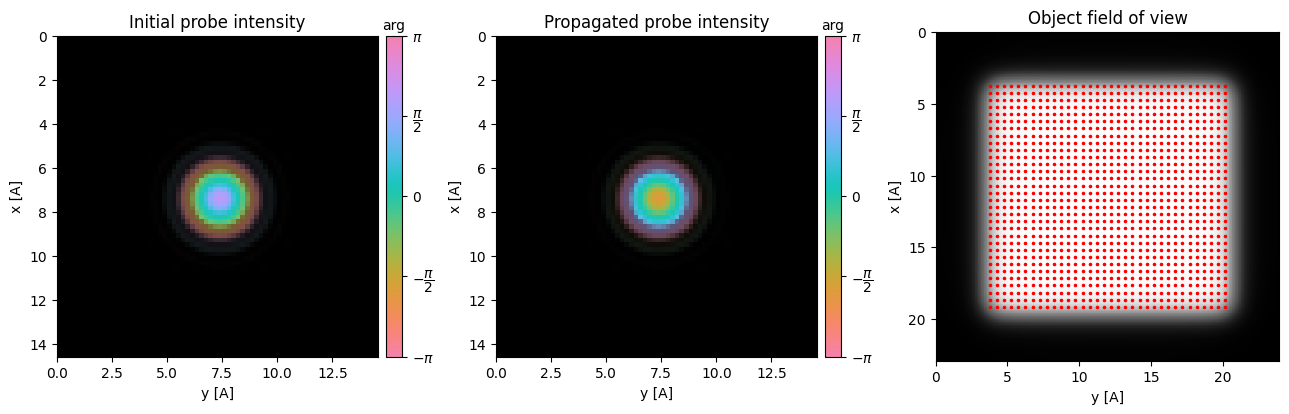

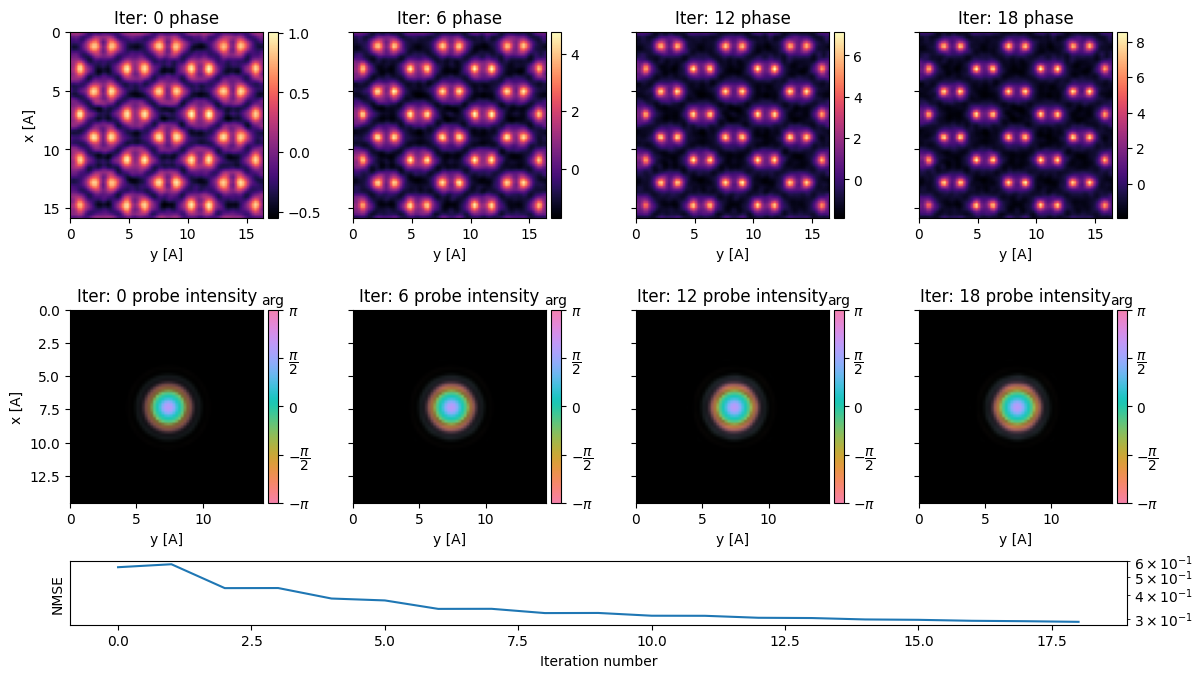

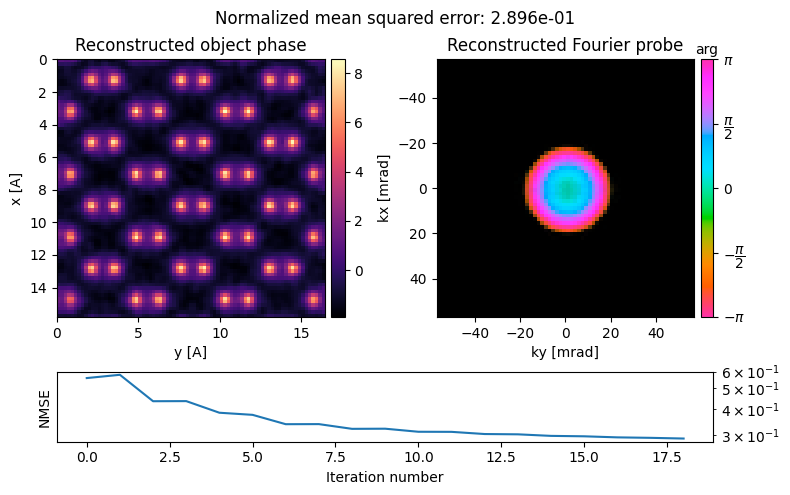

In [ ]:

################################ Final optimized params ###############################

max_input = all_input[np.argmin(all_value)]

print('Final optimized params')
print('semiangle_cutoff:',max_input[0])
print('defocus:',max_input[1])
print('energy:',max_input[2])
print('max_iter:',max_input[3])
print('step_size:',max_input[4])
print('identical_slices_iter:',max_input[5])
print('slice_thicknesses:',max_input[6])
print('num_slices:',max_input[7])

print('NMSE:',cu_Y)


################################ Visualization with final optimized params ###############################

oracle_show(max_input)

In [ ]:



################################ End of Part III ################################




################################################################################

---------------------------------------------------------------------------- That's all folks ! ----------------------------------------------------------------------------


################################################################################